In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import seaborn as sns
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# vars for where zmaps are stored
# INPUT_DIR = '/home/users/nklevak/network_data/'
INPUT_DIR = '/home/users/nklevak/network_data_updated/'
os.makedirs(INPUT_DIR, exist_ok=True)

# relevant task and contrast data
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

max_num_encounters = 5

In [3]:
# load the zmaps
def load_zmaps_with_metadata(input_dir):
    """
    Load z-statistic maps and their metadata from a BIDS-like directory structure.
    
    Parameters:
    -----------
    input_dir : str
        Directory where files were saved.
        
    Returns:
    --------
    dict
        Nested dictionary containing loaded zmaps and metadata, organized by task, contrast, and encounter.
    """
    # Initialize nested defaultdict to store the loaded data
    loaded_data = defaultdict(lambda: defaultdict(dict))
    
    # Track number of files loaded
    num_files_loaded = 0
    
    # Walk through the directory structure
    for task_name in os.listdir(input_dir):
        task_dir = os.path.join(input_dir, task_name)
        
        # Skip if not a directory
        if not os.path.isdir(task_dir):
            continue
            
        for contrast_name in os.listdir(task_dir):
            contrast_dir = os.path.join(task_dir, contrast_name)
            
            # Skip if not a directory
            if not os.path.isdir(contrast_dir):
                continue
                
            # Find all .nii.gz files in this contrast directory
            for filename in os.listdir(contrast_dir):
                if filename.endswith('.nii.gz'):
                    # Extract base filename without extension
                    base_filename = filename.replace('.nii.gz', '')
                    
                    # Check if corresponding JSON metadata exists
                    json_path = os.path.join(contrast_dir, f"{base_filename}.json")
                    if not os.path.exists(json_path):
                        print(f"Warning: No metadata found for {filename}")
                        continue
                    
                    # Load the image
                    img_path = os.path.join(contrast_dir, filename)
                    zmap = nib.load(img_path)
                    
                    # Load the metadata
                    with open(json_path, 'r') as f:
                        metadata = json.load(f)
                    
                    # Get encounter index (0-based)
                    encounter_idx = metadata["EncounterNumber"] - 1
                    
                    # Store both the image and metadata
                    loaded_data[task_name][contrast_name][encounter_idx] = {
                        'zmap': zmap,
                        'metadata': metadata
                    }
                    
                    num_files_loaded += 1
    
    print(f"Loaded {num_files_loaded} z-statistic maps with metadata.")
    return loaded_data

In [4]:
loaded_zmaps = load_zmaps_with_metadata(INPUT_DIR)

Loaded 211 z-statistic maps with metadata.


In [5]:
def gatherRelevantMaps(all_maps, req_tasks, req_contrasts, req_encounters):
    
    descriptors = [] #where we will insert the string name of the each included map
    rel_zmaps = []
    
    for task in req_tasks:
        if task not in TASKS:
            continue
    
        for contrast in req_contrasts[task]:
            if contrast not in CONTRASTS[task]:
                continue
    
            for encounter in req_encounters:
                if encounter < 0 or encounter >= max_num_encounters:
                    continue
    
                if (len(req_tasks) > 1):
                    descriptor_name = f"{task}:{contrast}:encounter-0{encounter + 1}"
                else:
                    descriptor_name = f"{task}:{contrast}:encounter-0{encounter + 1}"

                if task in all_maps.keys():
                    if contrast in all_maps[task].keys():
                        if encounter in all_maps[task][contrast].keys():
                            map = all_maps[task][contrast][encounter]["zmap"]

                            rel_zmaps.append(map)
                            descriptors.append(descriptor_name)
                        else:
                            print(f"{encounter} is not in zmap for {task},{contrast}")
                            continue
                    else:
                        print(f"{contrast} is not in zmap for {task}")
                        continue
                else:
                    print(f"{task} is not in zmap")
                    continue
    
    return rel_zmaps, descriptors

In [6]:
requested_tasks = TASKS
requested_contrasts = CONTRASTS # all of the contrasts
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)

4 is not in zmap for goNogo,nogo_success-go
4 is not in zmap for goNogo,nogo_success
4 is not in zmap for goNogo,task-baseline
4 is not in zmap for goNogo,response_time


## Masking to focus on specific networks before calculating correlations between sessions / contrasts / tasks

In [7]:
# download Yeo atlas
yeo = datasets.fetch_atlas_yeo_2011()
yeo_7network = yeo['thick_7'] 

network_names = {
    1: "Visual",
    2: "Somatomotor",
    3: "Dorsal Attention",
    4: "Ventral Attention",
    5: "Limbic",
    6: "Frontoparietal Control",
    7: "Default Mode"
}

zmaps_loaded = rel_zmaps # already NIFTI images
reference_map = zmaps_loaded[0]
# make the Yeo atlas be in the same space
yeo_resampled = image.resample_to_img(yeo_7network, reference_map, interpolation='nearest')

[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/yeo_2011

/tmp/ipykernel_24495/1497568342.py:18: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  yeo_resampled = image.resample_to_img(yeo_7network, reference_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [8]:
def get_yeo_network_corrs(zmaps, desc_list, yeo_img = yeo_resampled):
    """
    Calculate correlations between zmaps within each Yeo network.
    
    Parameters:
    -----------
    zmaps : list
        List of zmaps (NIfTI images)
    desc_list : list
        List of descriptions for each zmap (e.g., "task:contrast:encounter")
    yeo_img : NIfTI image
        Yeo atlas image
        
    Returns:
    --------
    dict
        Dictionary with results for each network
    """
    
    # go through each Yeo network and calculate correlations between relevant tasks/contrasts/encounters
    network_results = {}
    for network_id in range(1, 8):
        # Create mask for this network
        network_mask = image.math_img(f'img == {network_id}', img=yeo_img)
        
        # Extract data for all sessions within this network
        network_data = []
        for zmap in zmaps:
            masked_data = masking.apply_mask(zmap, network_mask)
            network_data.append(masked_data)
        
        # Convert to array
        data_array = np.array(network_data)
        
        if data_array.shape[1] > 1:
            # Calculate correlation matrix between all sessions/contrasts
            corr_matrix = np.corrcoef(data_array)
            
            # Store results
            network_results[network_names[network_id]] = {
                'correlation_matrix': corr_matrix,
                'mean_correlation': np.mean(np.triu(corr_matrix, k=1)),
                'voxel_count': data_array.shape[1],
                'descriptions': desc_list
            }
        else:
            network_results[network_names[network_id]] = {
                'correlation_matrix': np.array([]),
                'mean_correlation': np.nan,
                'voxel_count': data_array.shape[1],
                'descriptions': desc_list
            }
    return network_results

In [9]:
def plot_network_correlations(network_results, network_name, mask_lower=True):
    """
    Plot correlation matrix for a specific network with proper labels.
    
    Parameters:
    -----------
    network_results : dict
        Results from get_yeo_network_corrs function
    network_name : str
        Name of the network to plot (e.g., "Frontoparietal Control")
    """
    if network_name not in network_results:
        print(f"Network {network_name} not found in results")
        return
    
    result = network_results[network_name]
    
    if result['correlation_matrix'].size == 0:
        print(f"No correlation data available for {network_name} network")
        return
    
    # Get correlation matrix and descriptions
    corr_matrix = result['correlation_matrix']
    labels = result['descriptions']

    # Create the appropriate mask
    if mask_lower:
        # Create a mask for the lower triangle (without transposing)
        mask = np.triu(np.ones_like(corr_matrix), k=1)
    else:
        # Just mask the diagonal to keep all data visible
        mask = np.zeros_like(corr_matrix)
    
    # Plot
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask, vmin=-1, vmax=1, 
                annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
    # plt.xticks(rotation=45)
    plt.title(f"Correlations in {network_name} Network")
    plt.tight_layout()
    
    return plt.gcf()

In [10]:
# TEST: run this with nBack
requested_tasks = ["nBack"]
requested_contrasts = {}
requested_contrasts["nBack"] = CONTRASTS["nBack"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)

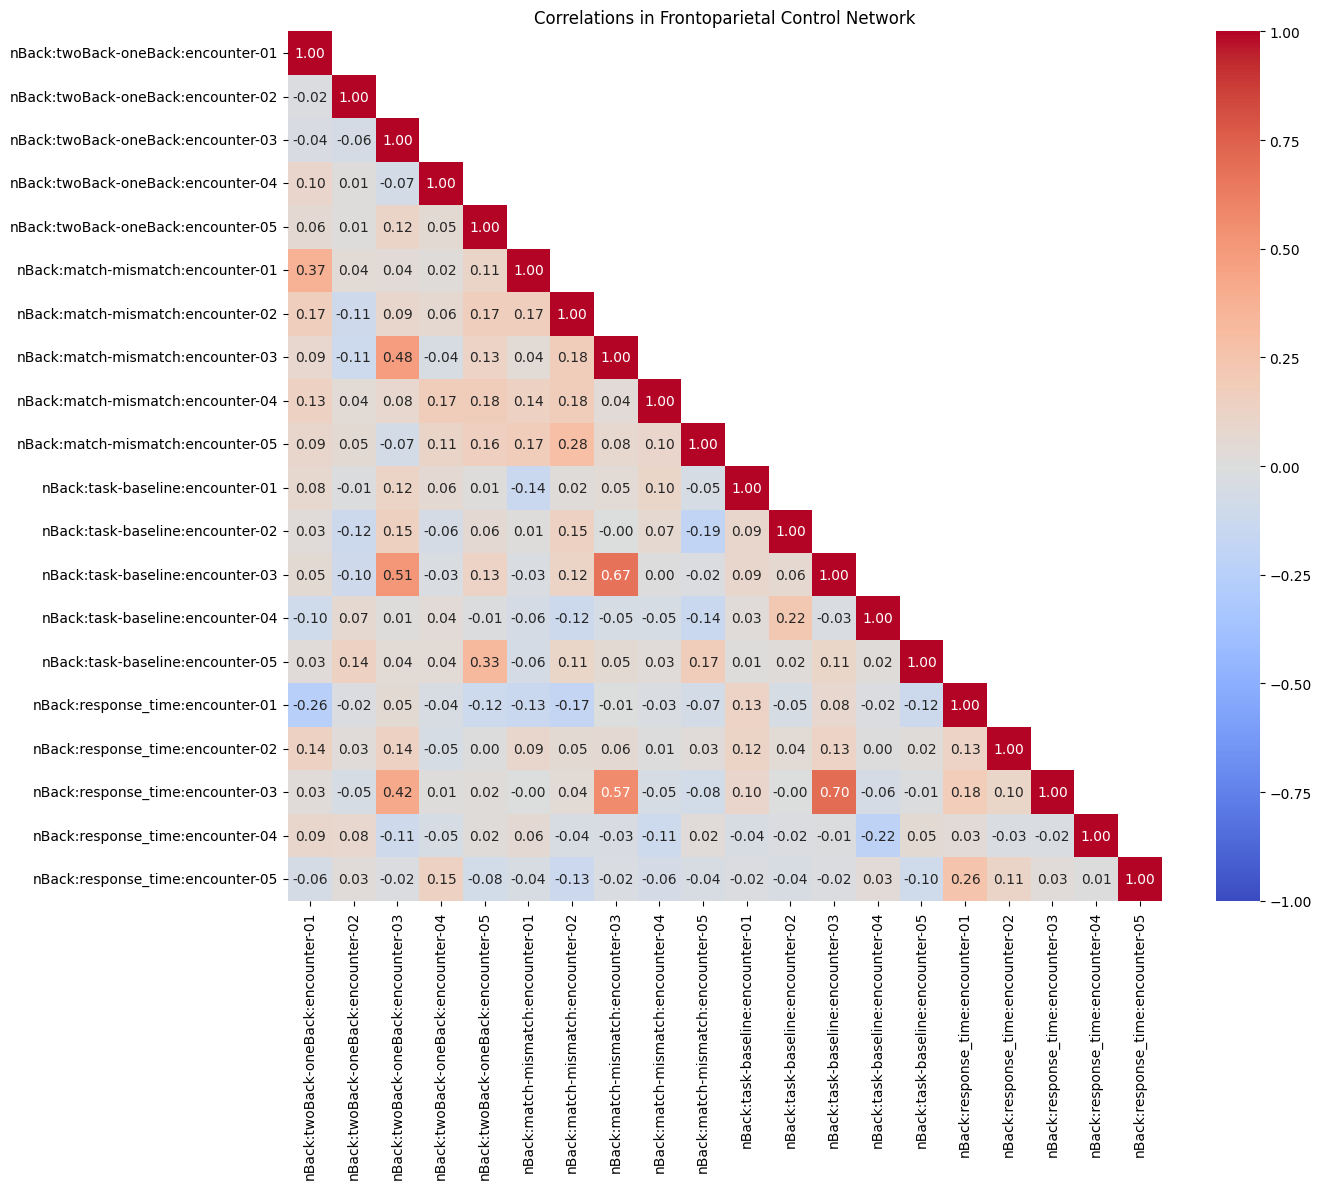

In [11]:
fig_nBack = plot_network_correlations(net_results, network_names[6])

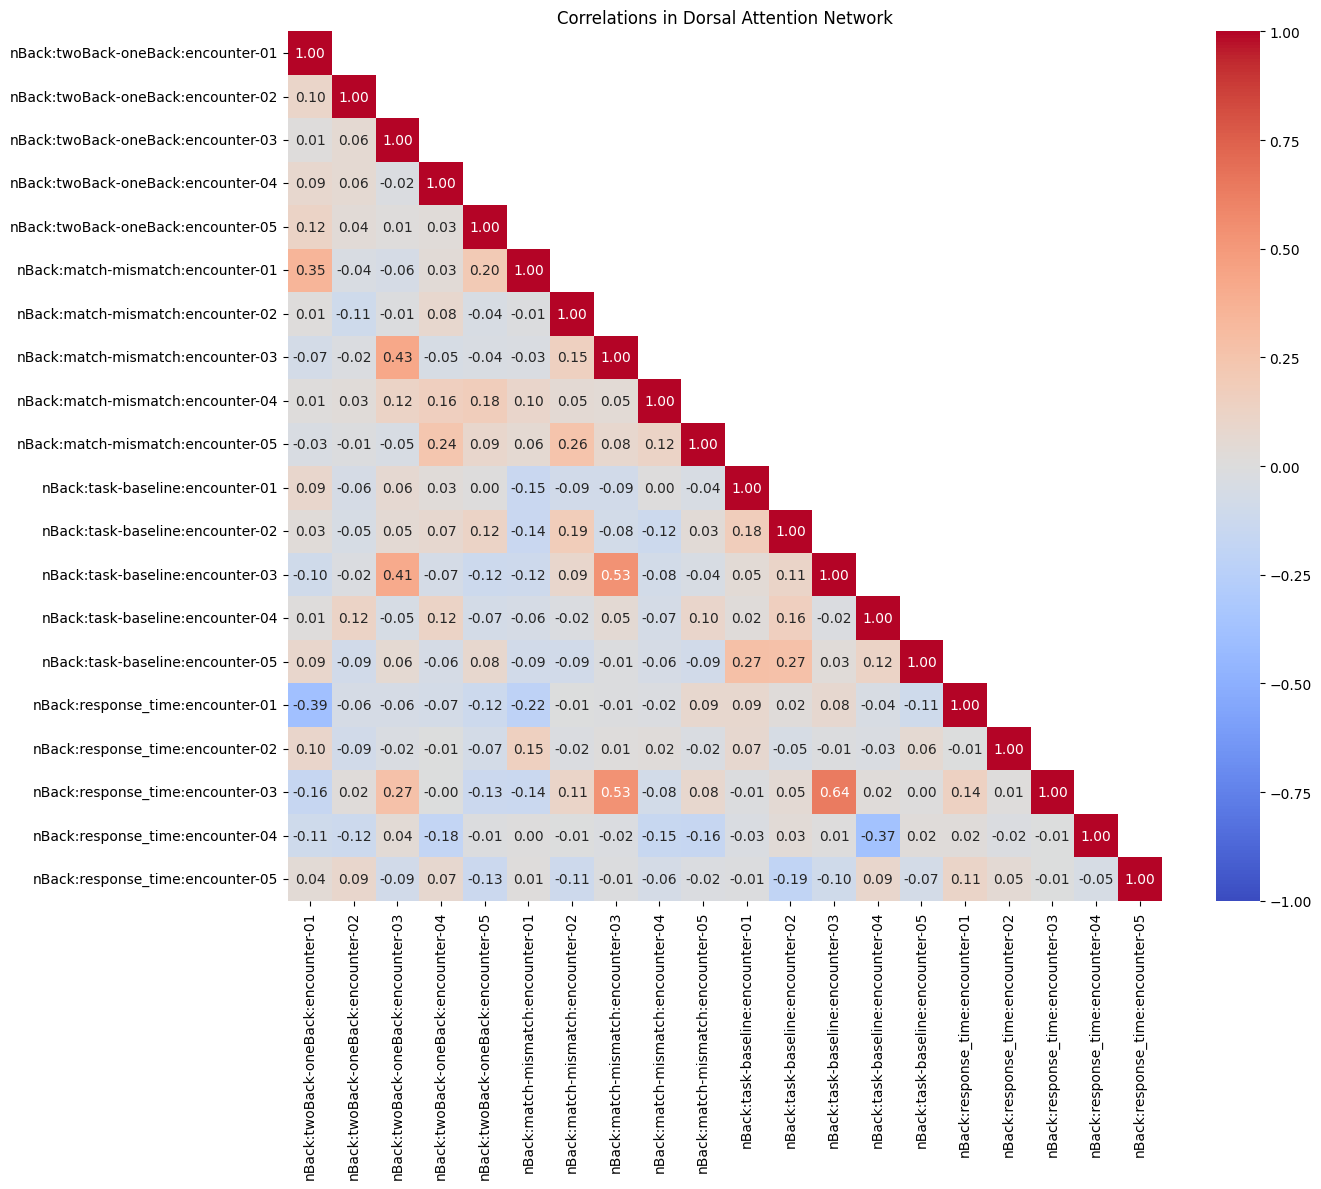

In [12]:
fig_nBack = plot_network_correlations(net_results, network_names[3])

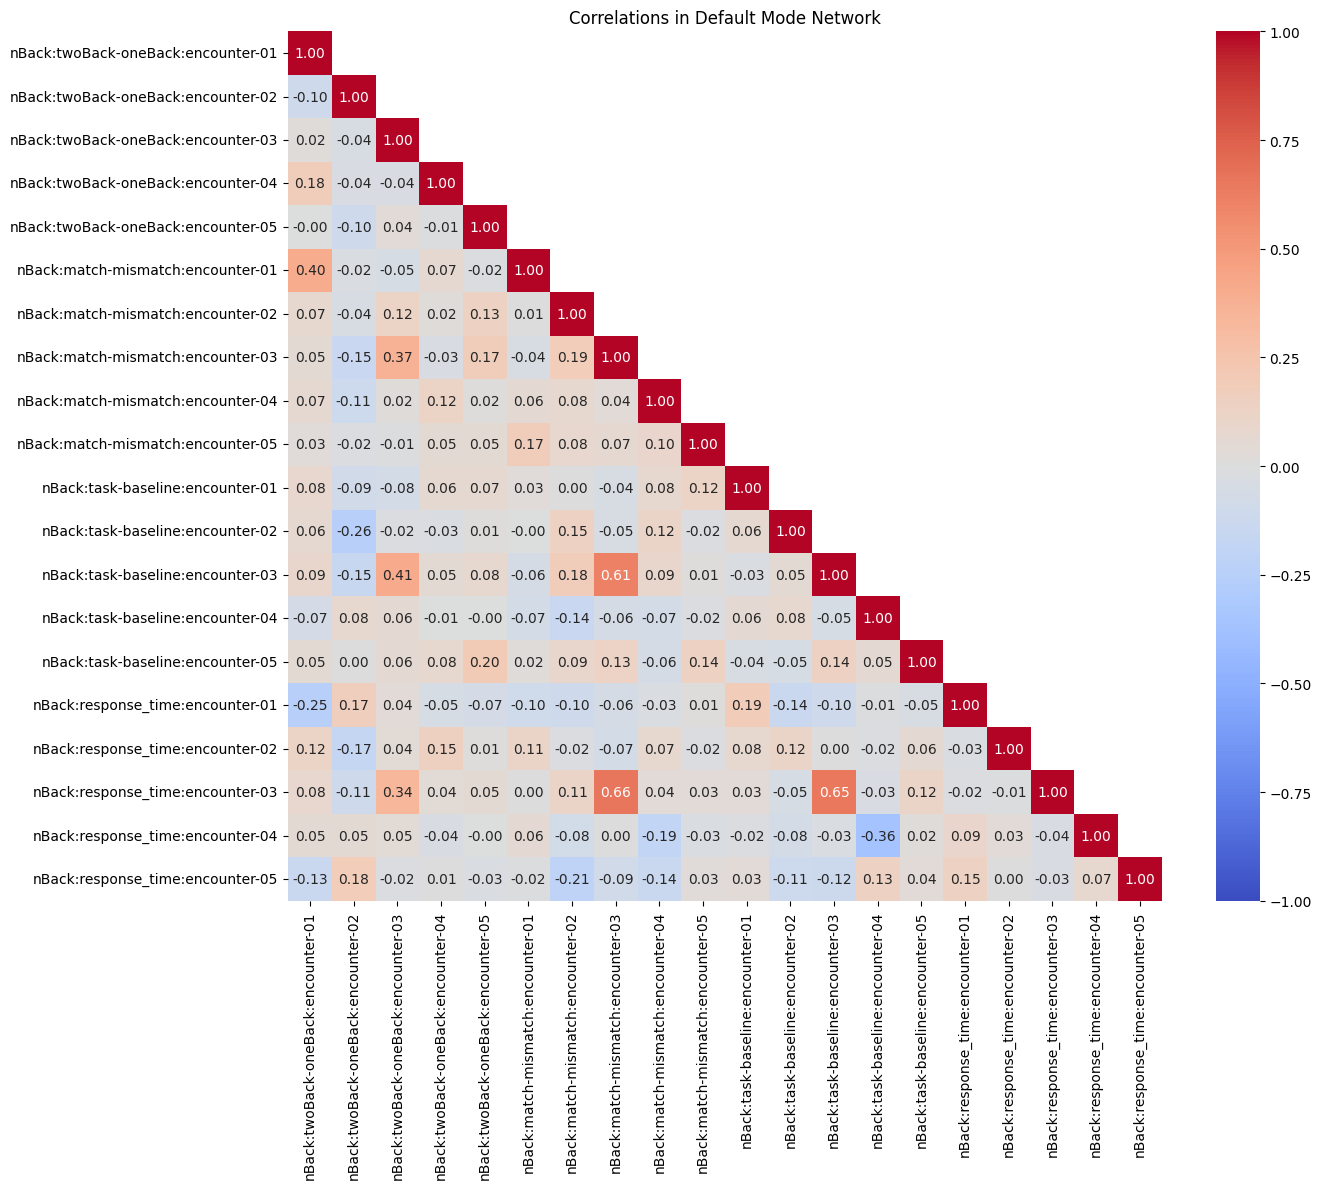

In [13]:
fig_nBack = plot_network_correlations(net_results, network_names[7])

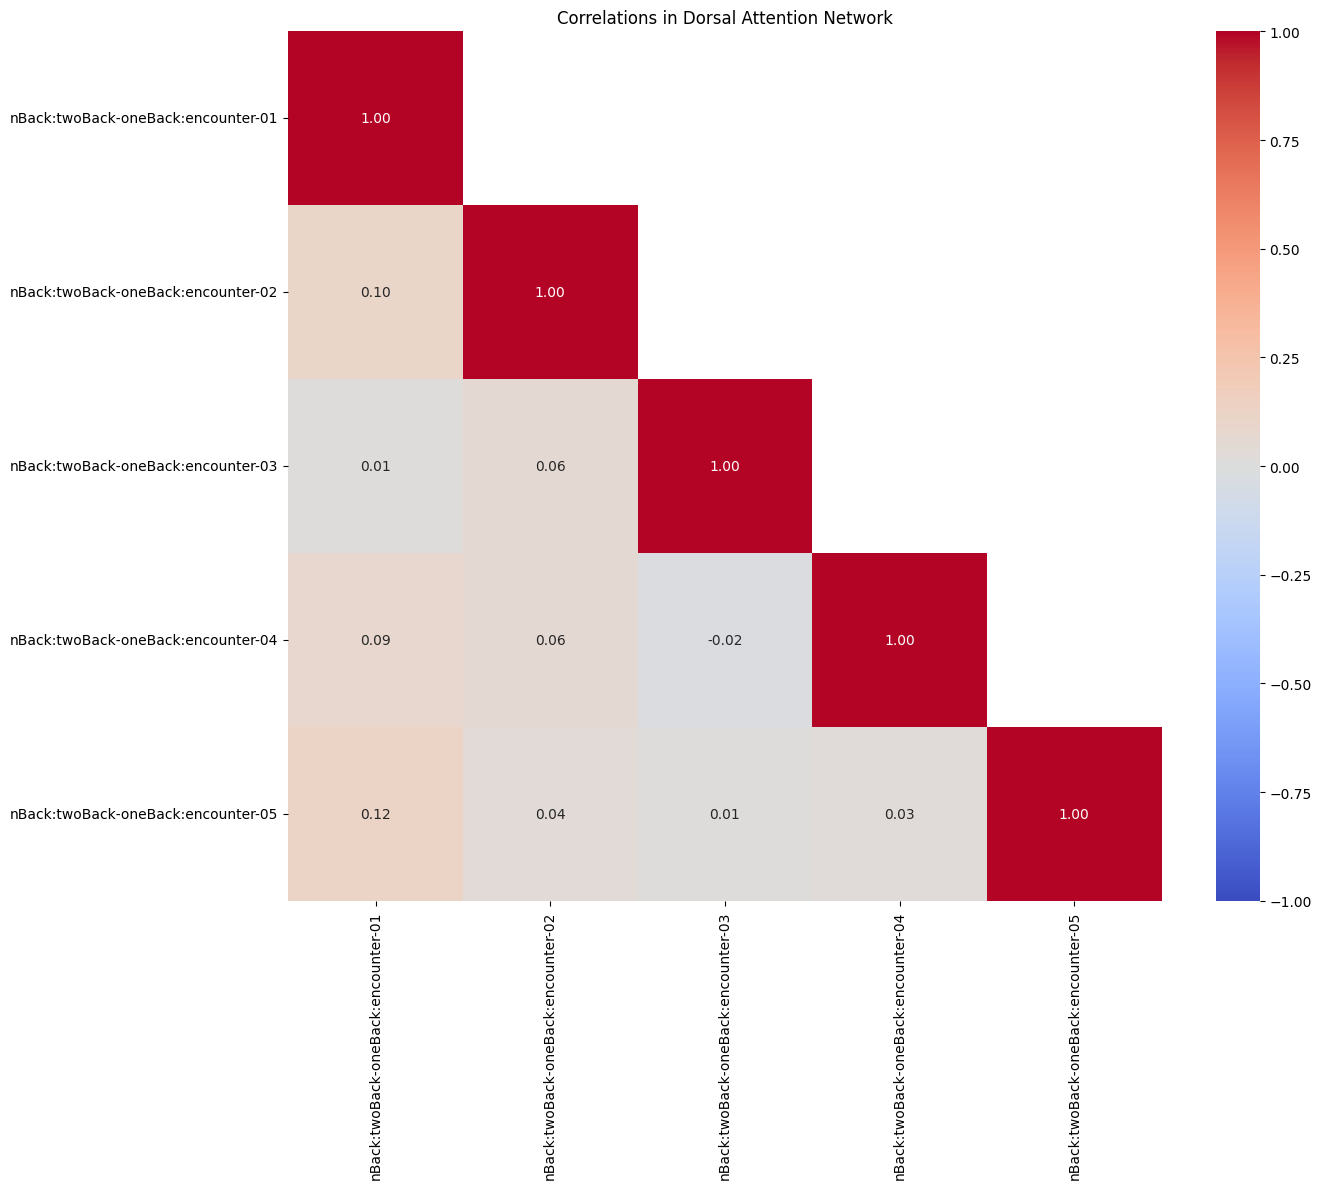

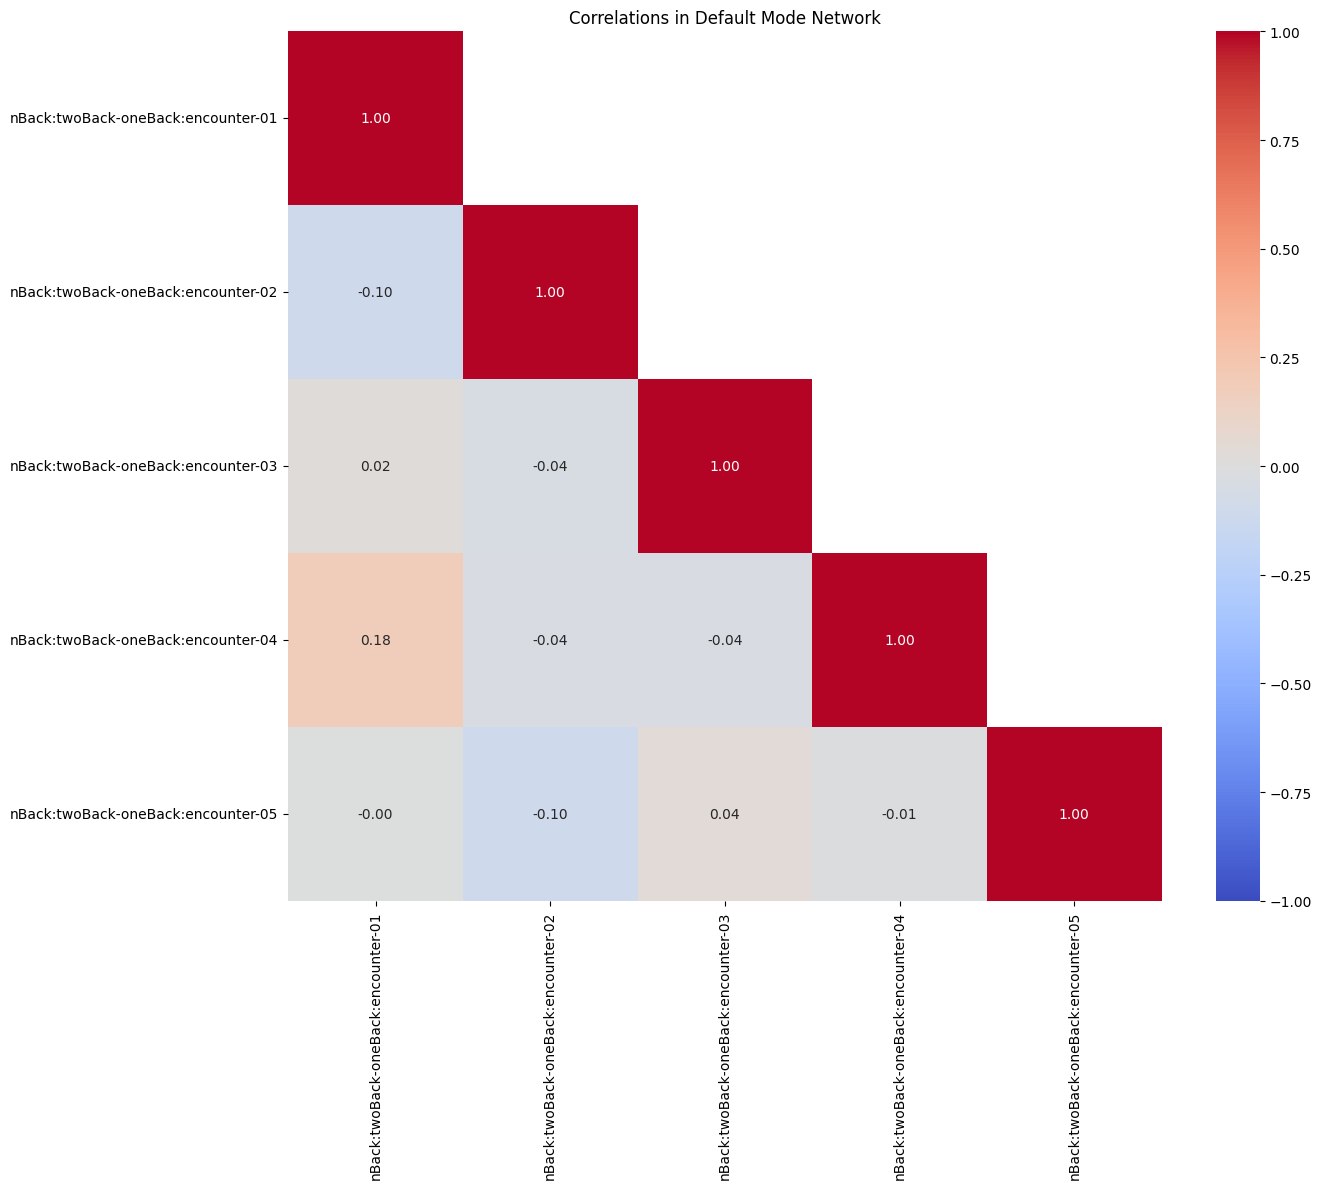

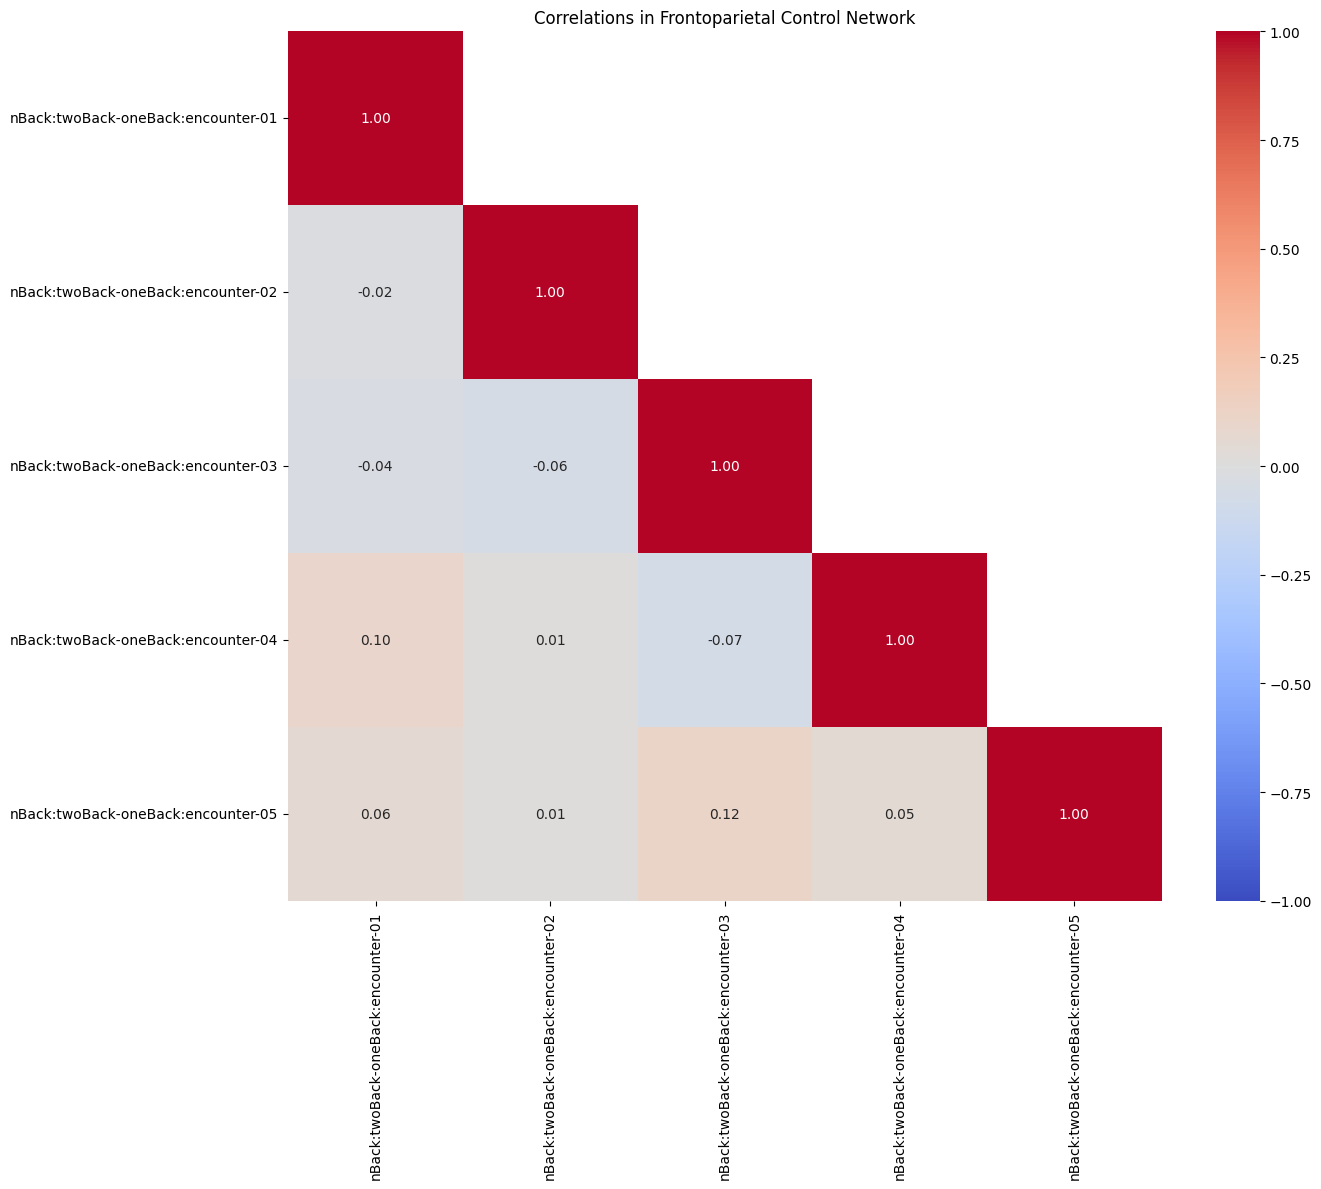

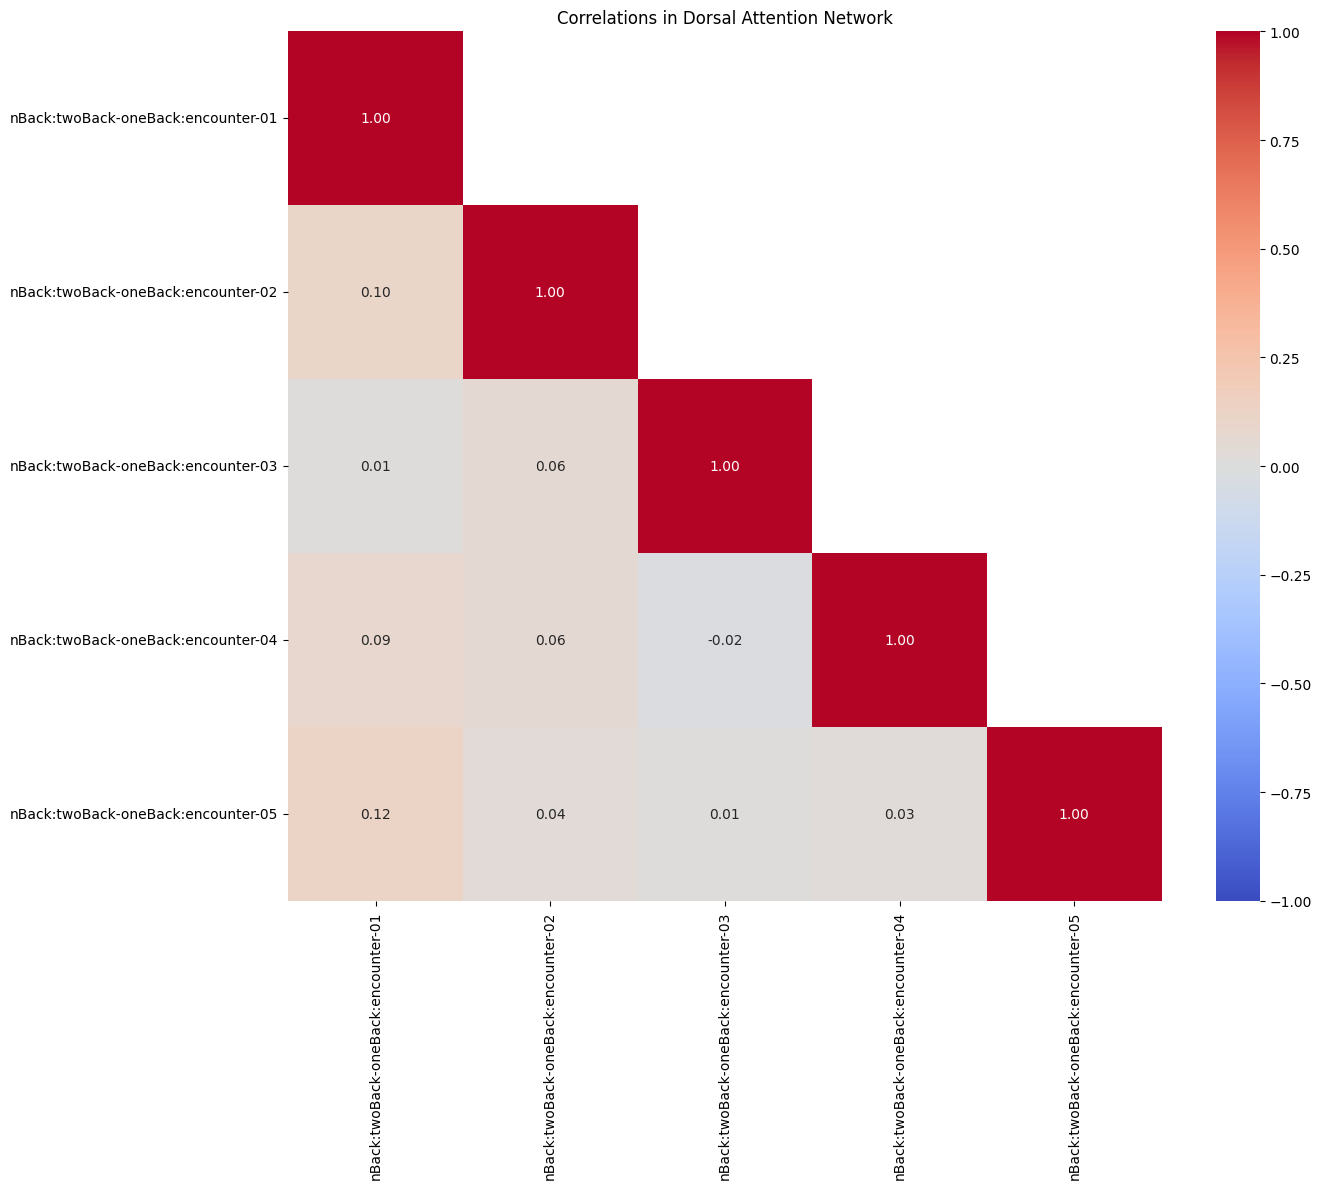

In [14]:
# TEST: run this with nBack one contrast at a time
requested_tasks = ["nBack"]
requested_contrasts = {}
# requested_contrasts["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"]
requested_contrasts["nBack"] = ["twoBack-oneBack"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[7])
plot_network_correlations(net_results, network_names[6])
plot_network_correlations(net_results, network_names[3])


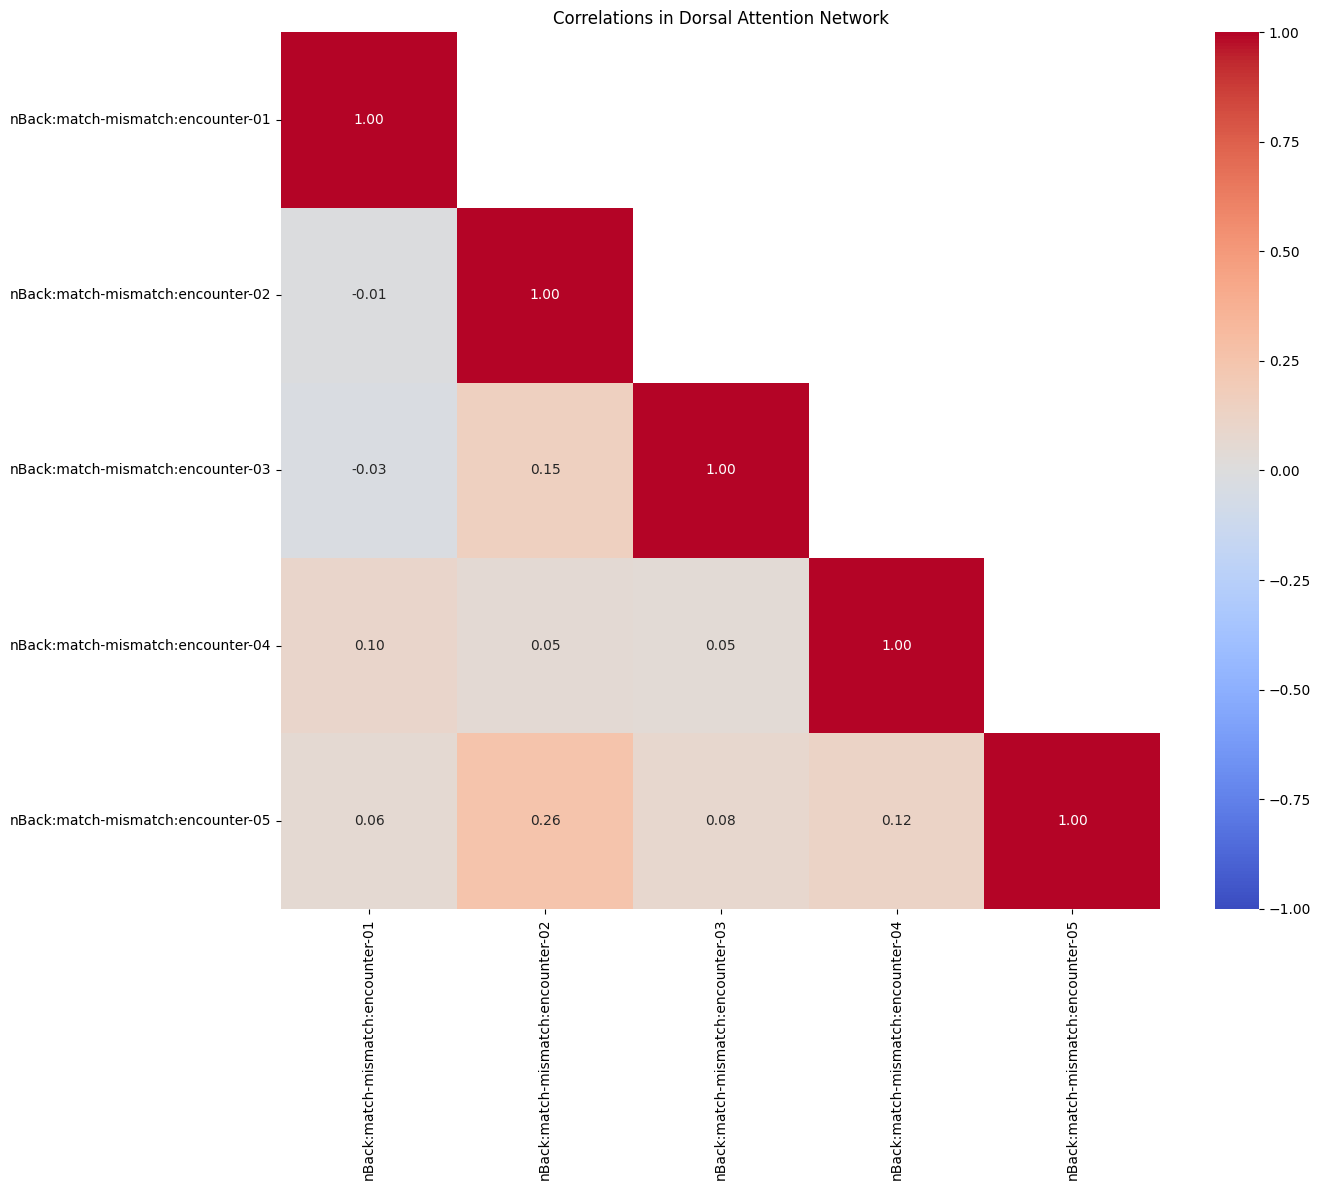

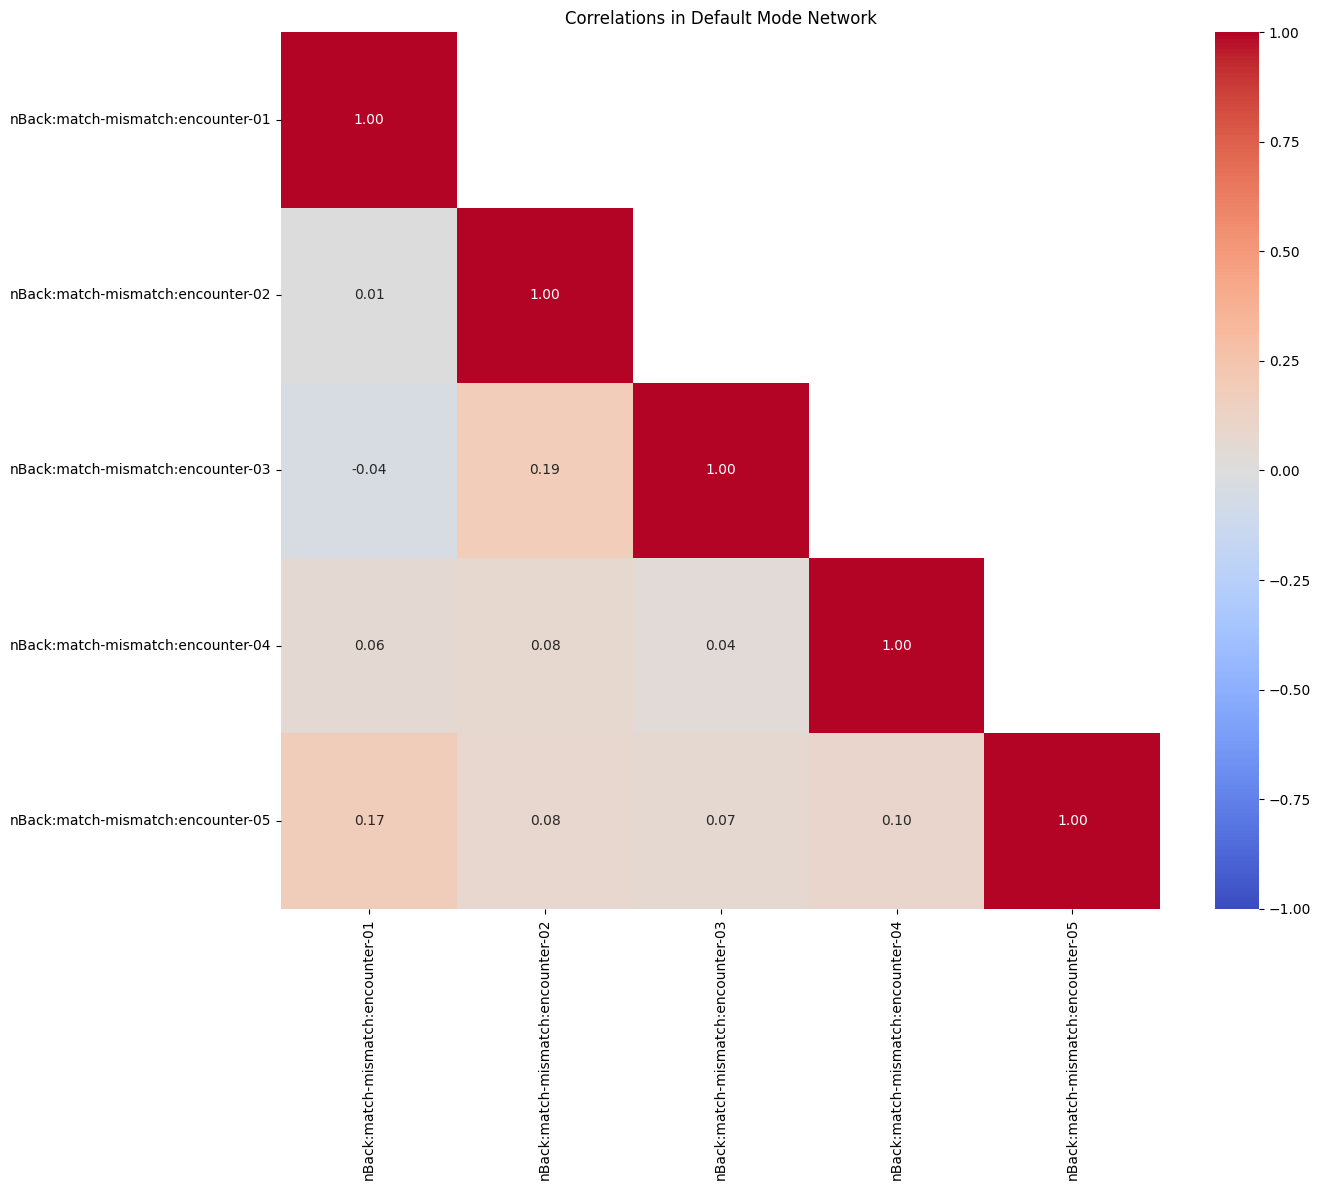

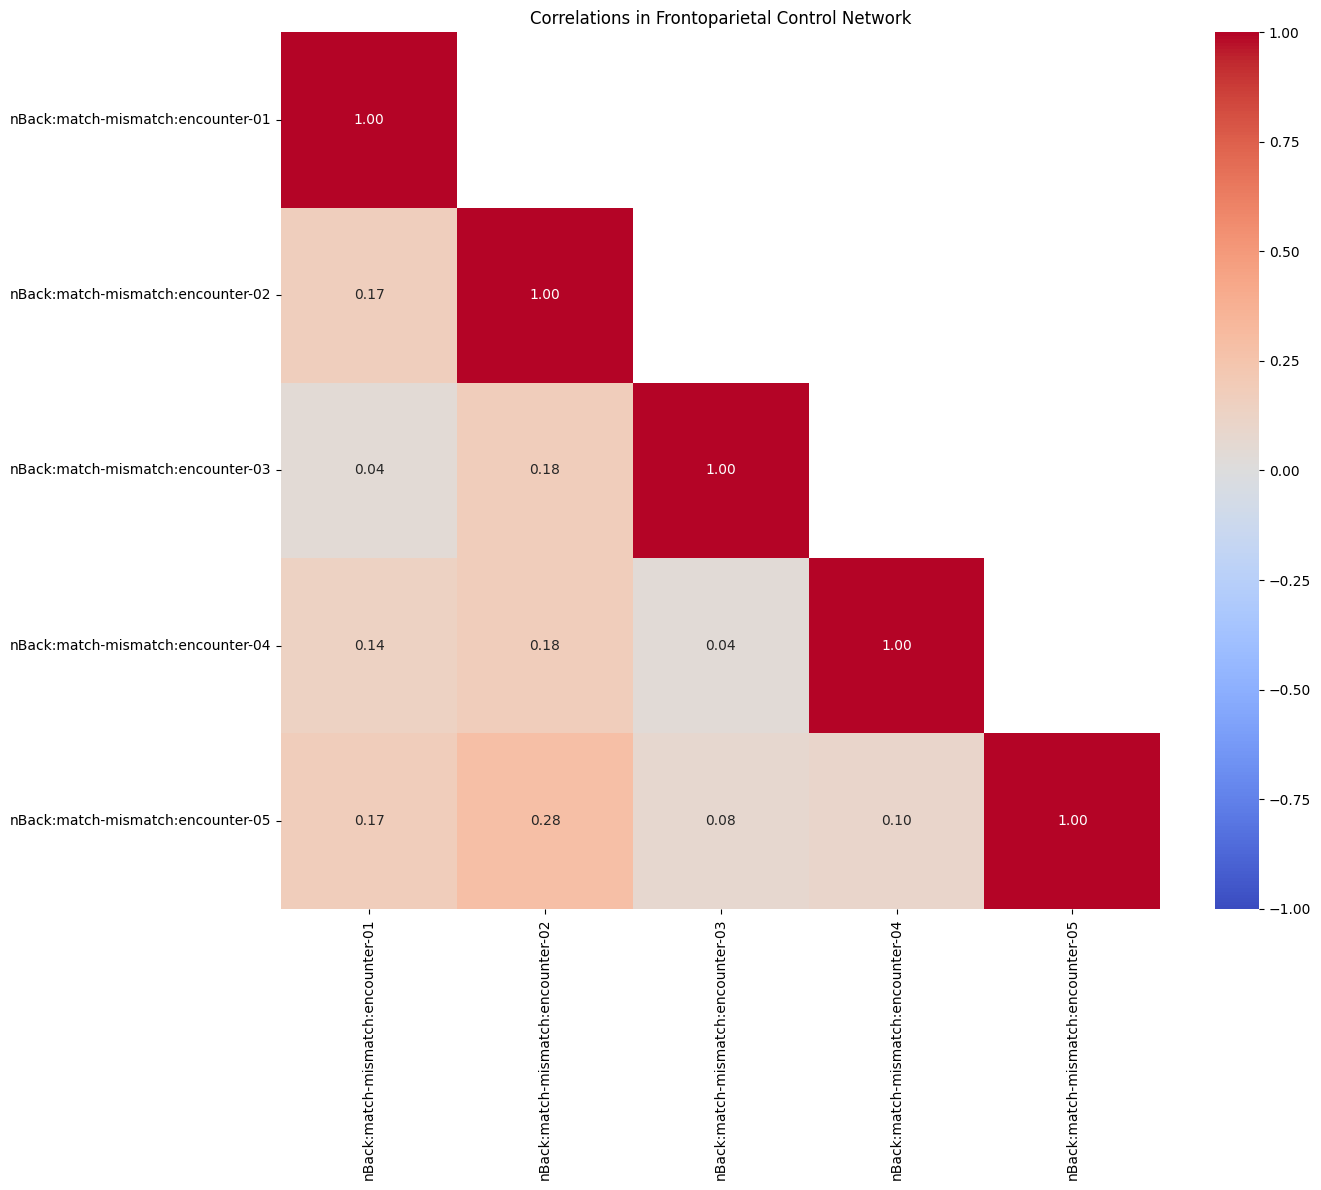

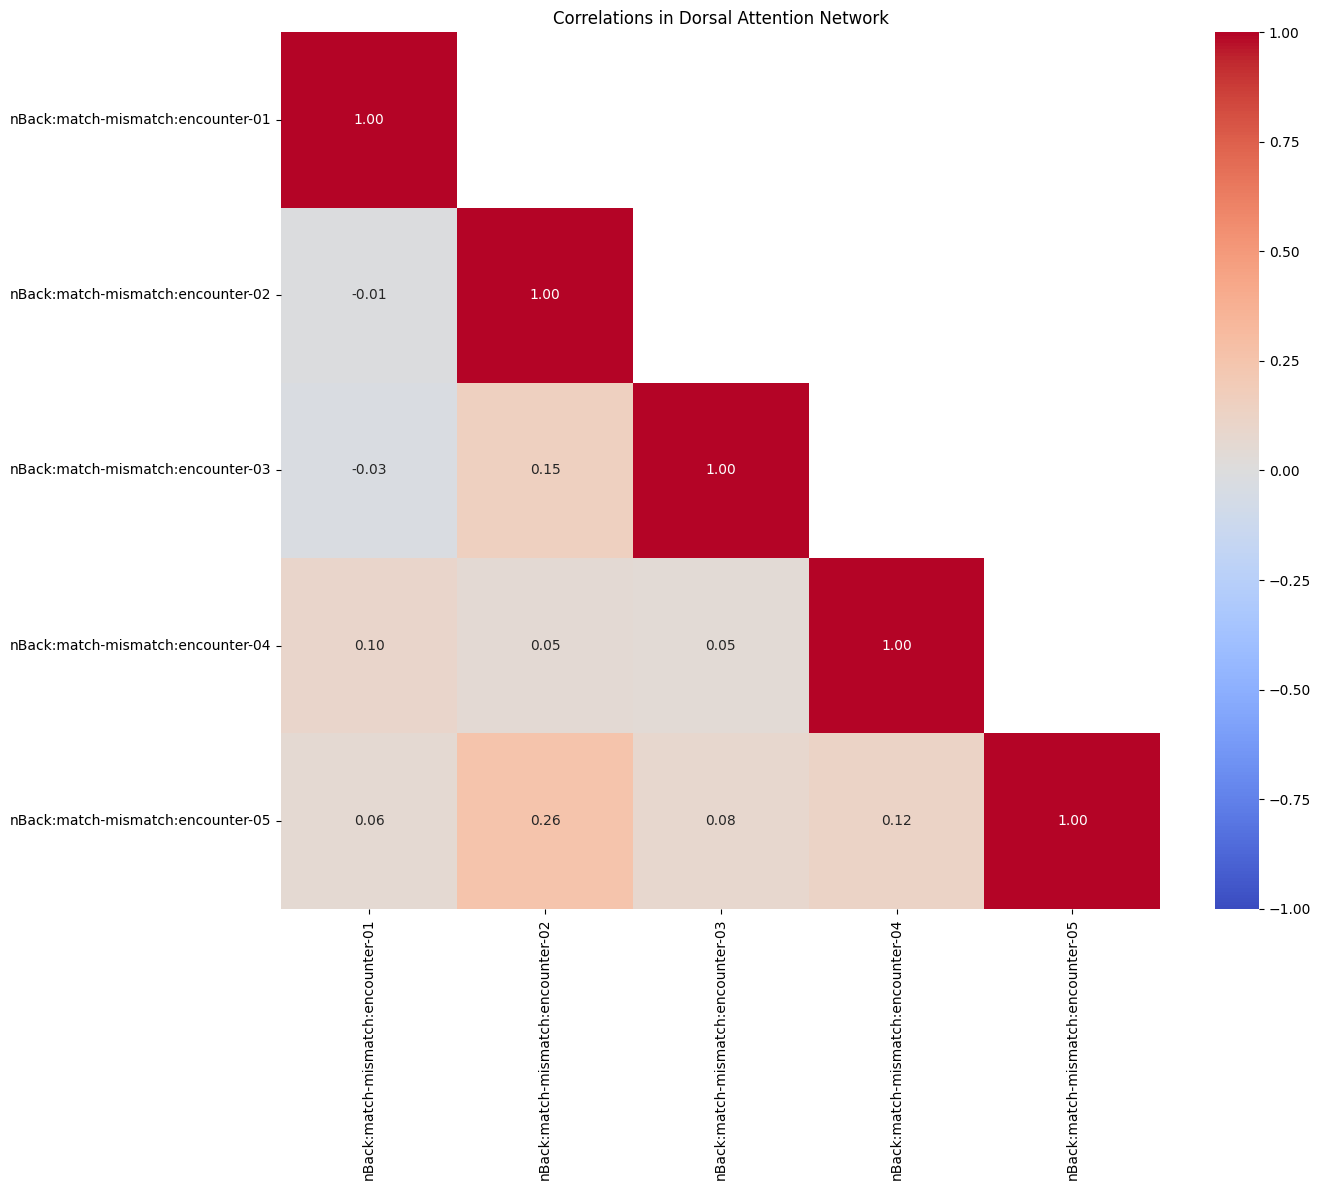

In [15]:
# TEST: run this with nBack one contrast at a time
requested_tasks = ["nBack"]
requested_contrasts = {}
# requested_contrasts["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"]
requested_contrasts["nBack"] = ["match-mismatch"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[7])
plot_network_correlations(net_results, network_names[6])
plot_network_correlations(net_results, network_names[3])


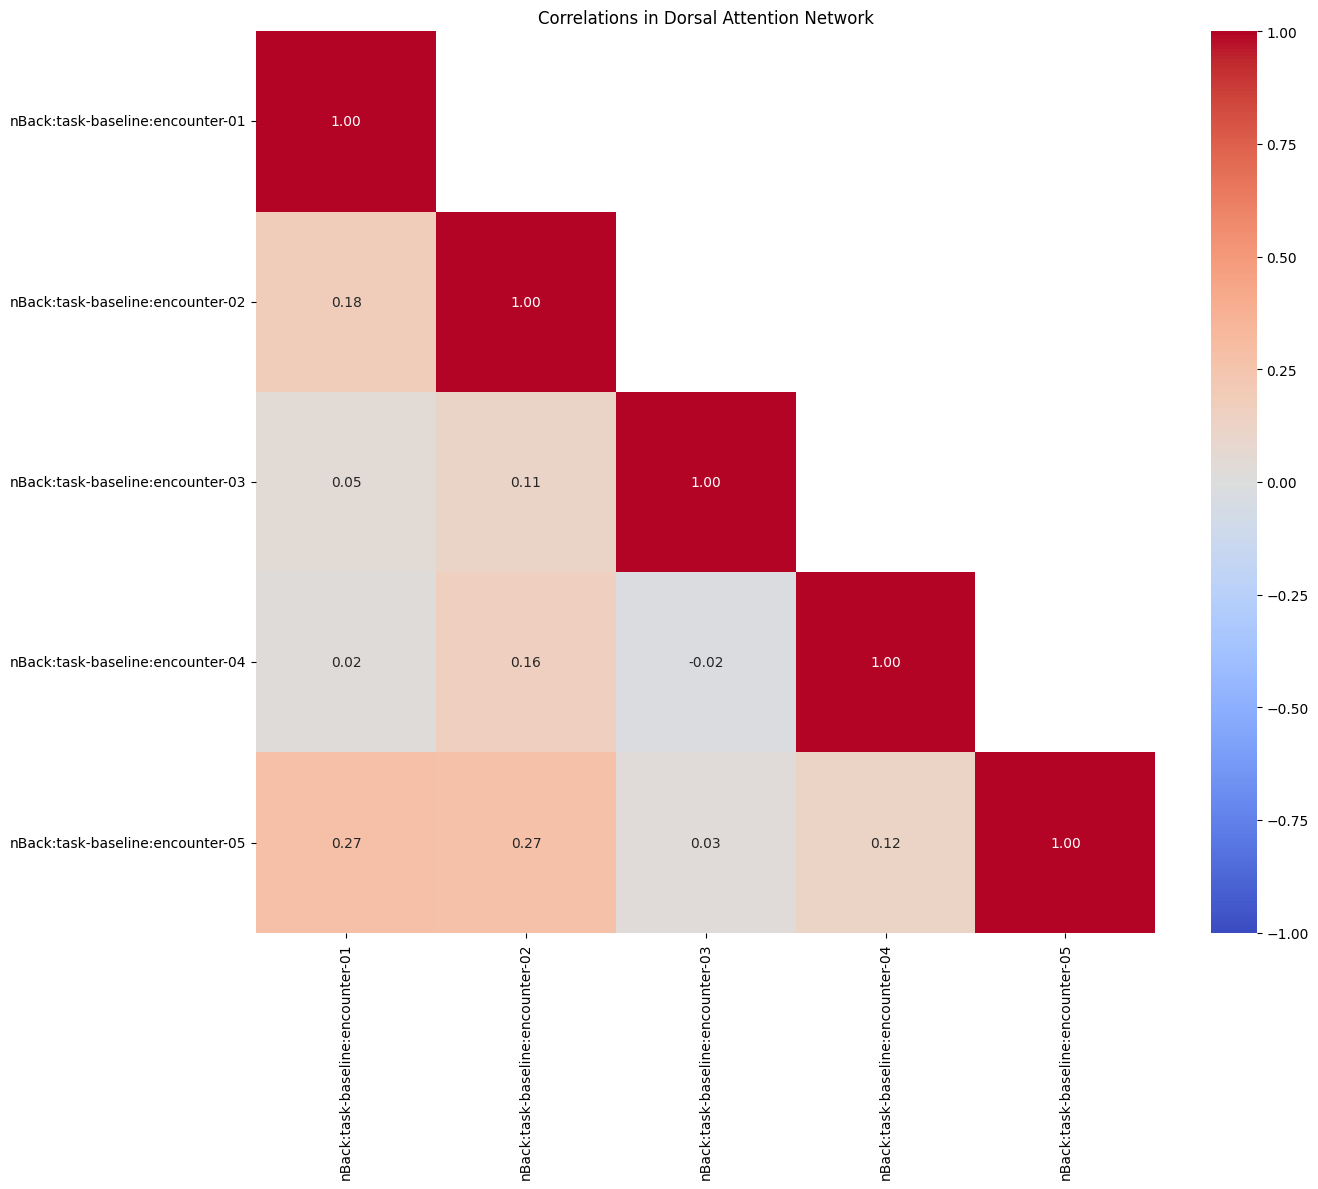

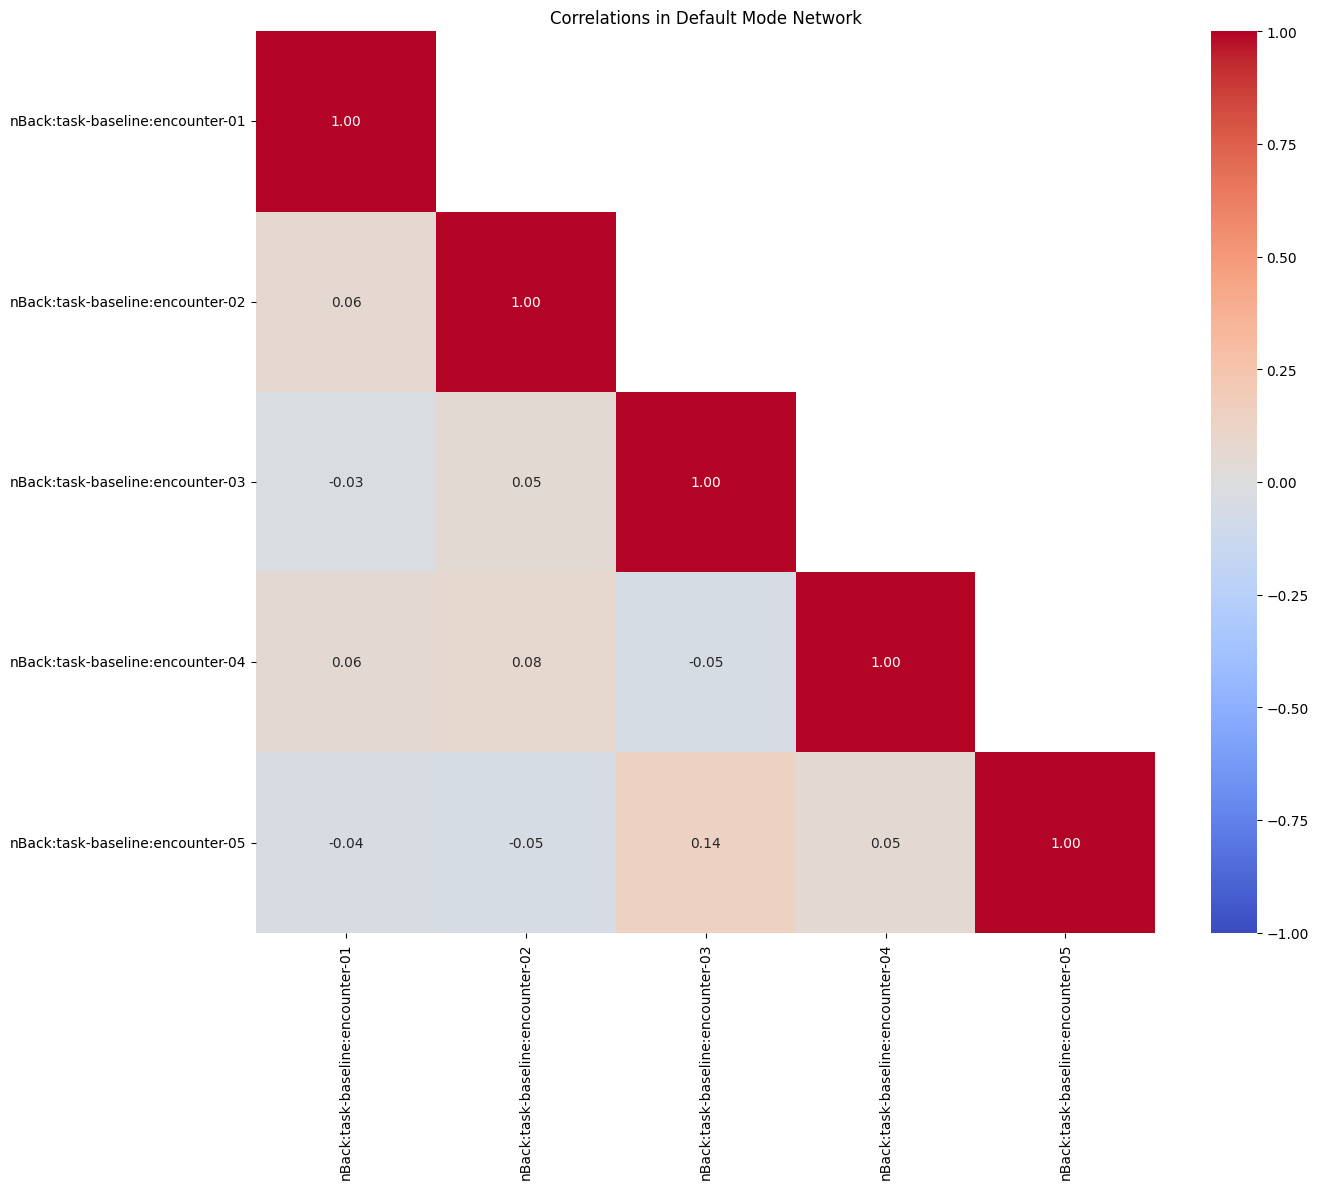

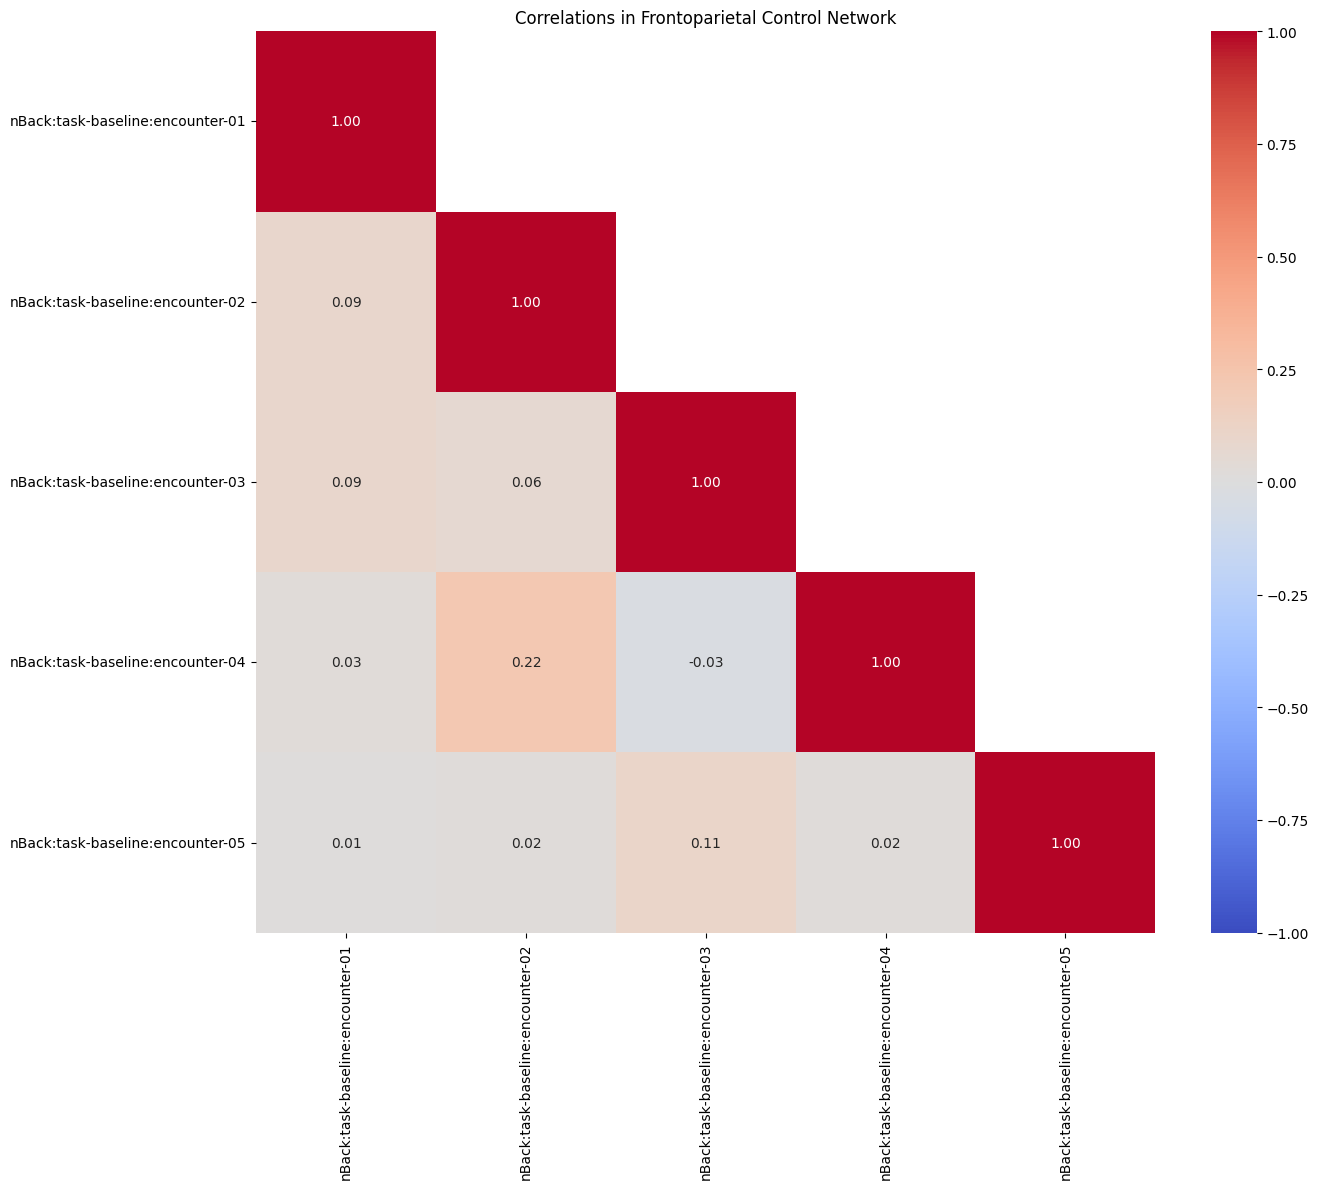

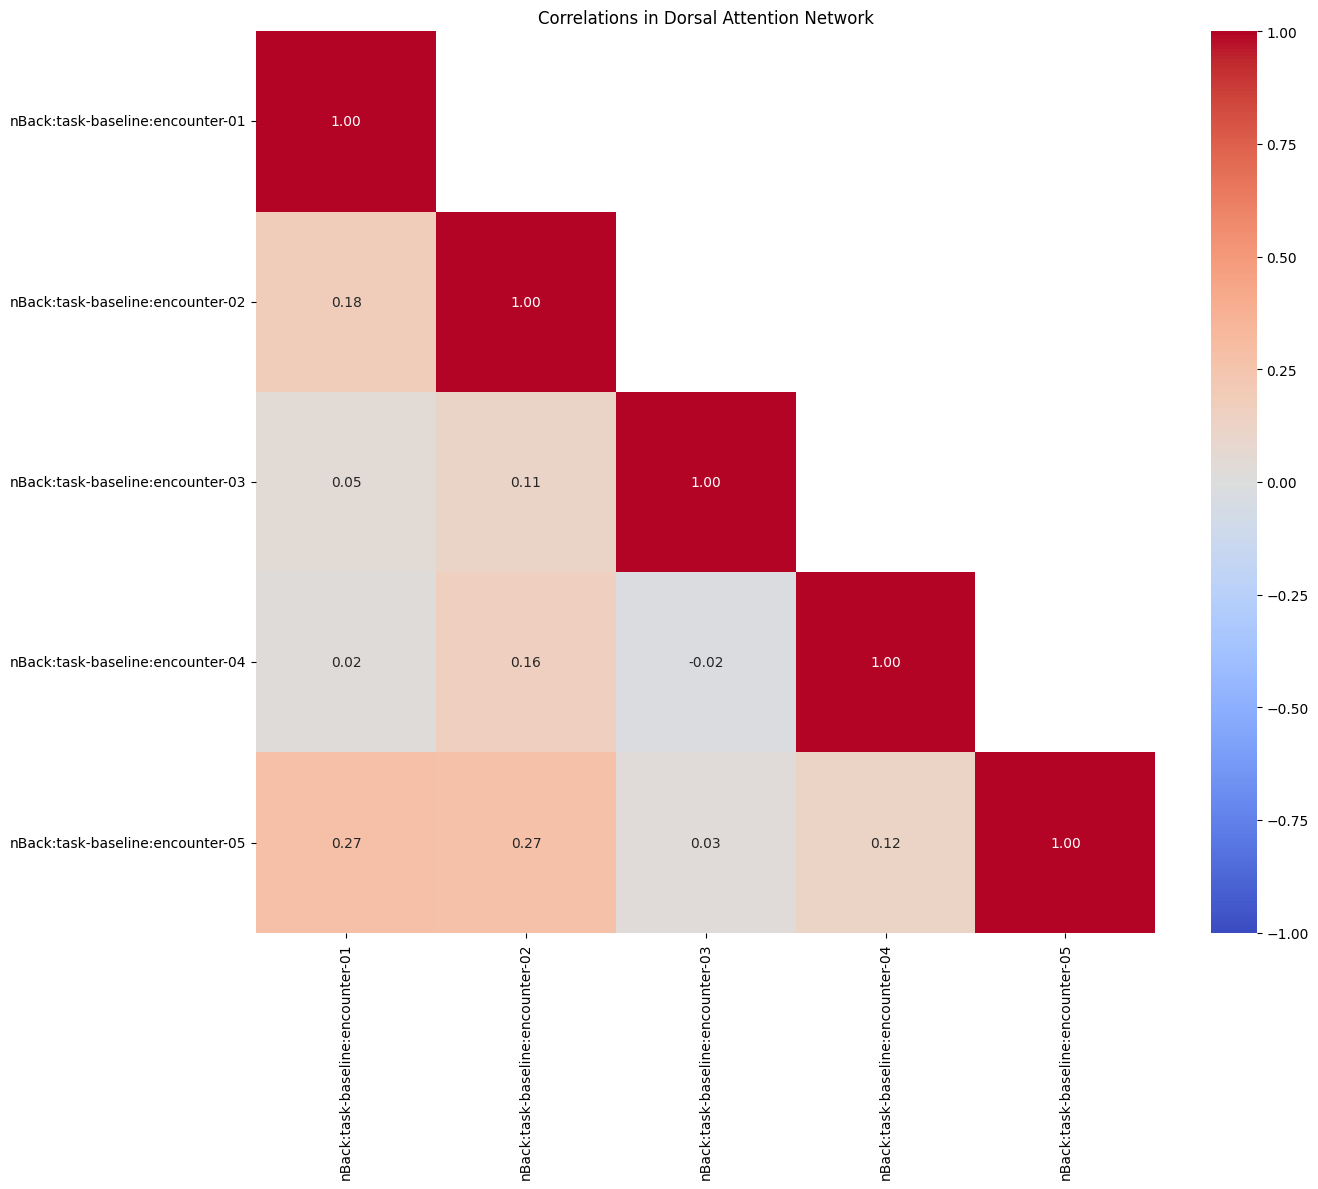

In [16]:
# TEST: run this with nBack one contrast at a time
requested_tasks = ["nBack"]
requested_contrasts = {}
# requested_contrasts["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"]
requested_contrasts["nBack"] = ["task-baseline"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[7])
plot_network_correlations(net_results, network_names[6])
plot_network_correlations(net_results, network_names[3])

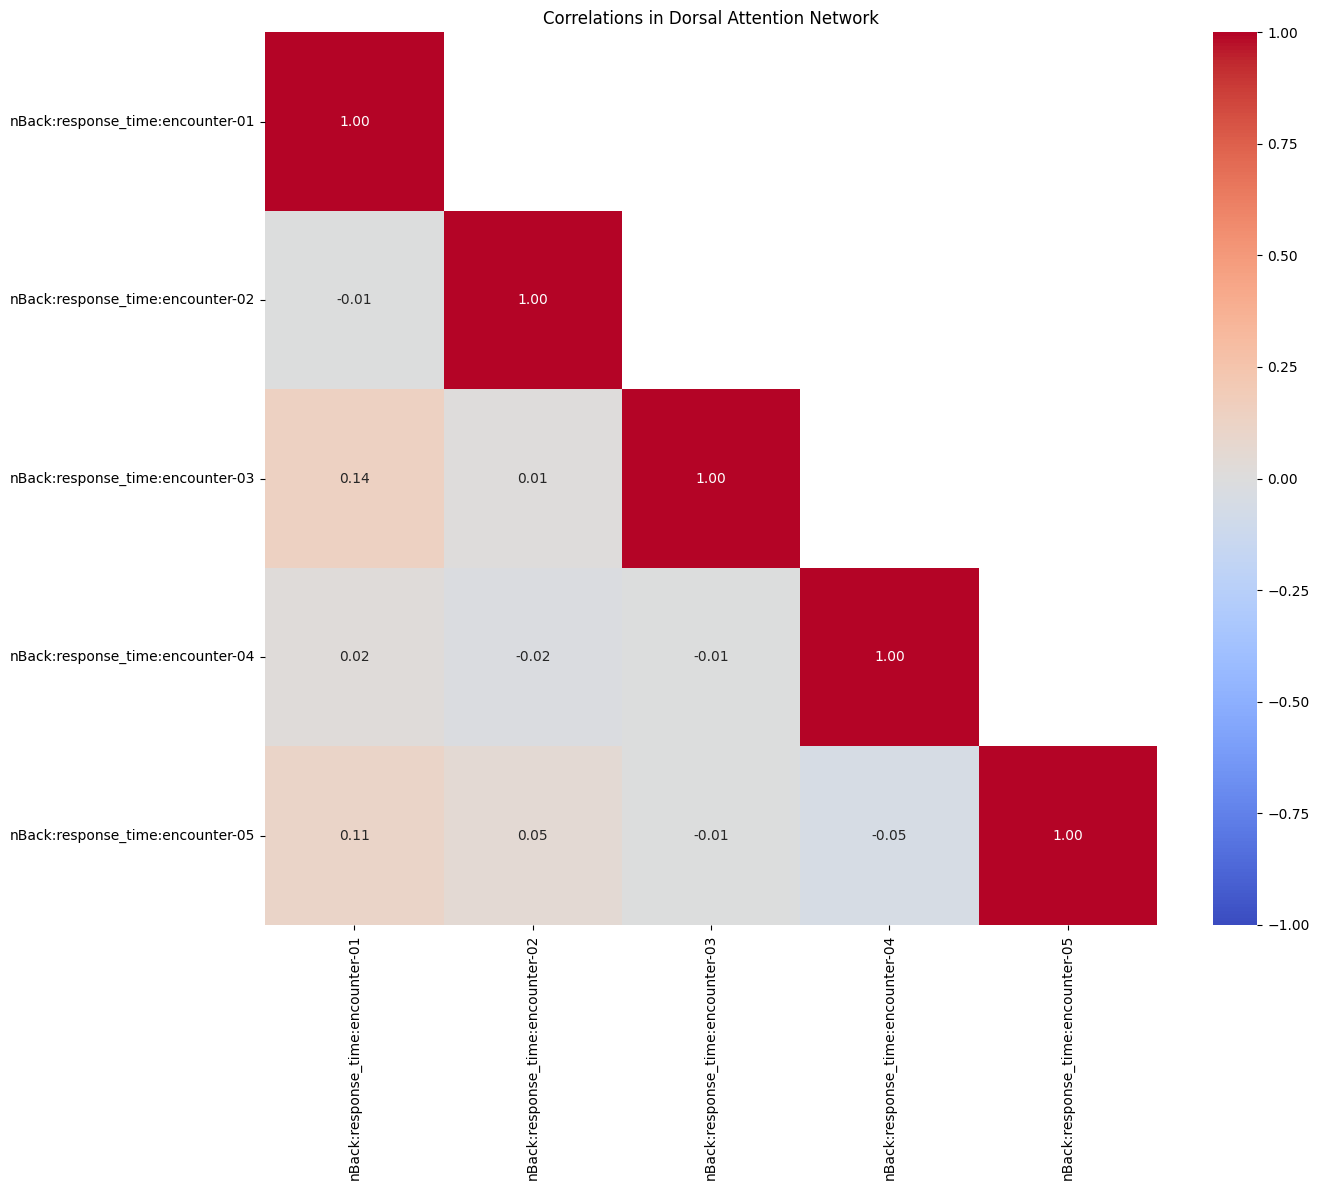

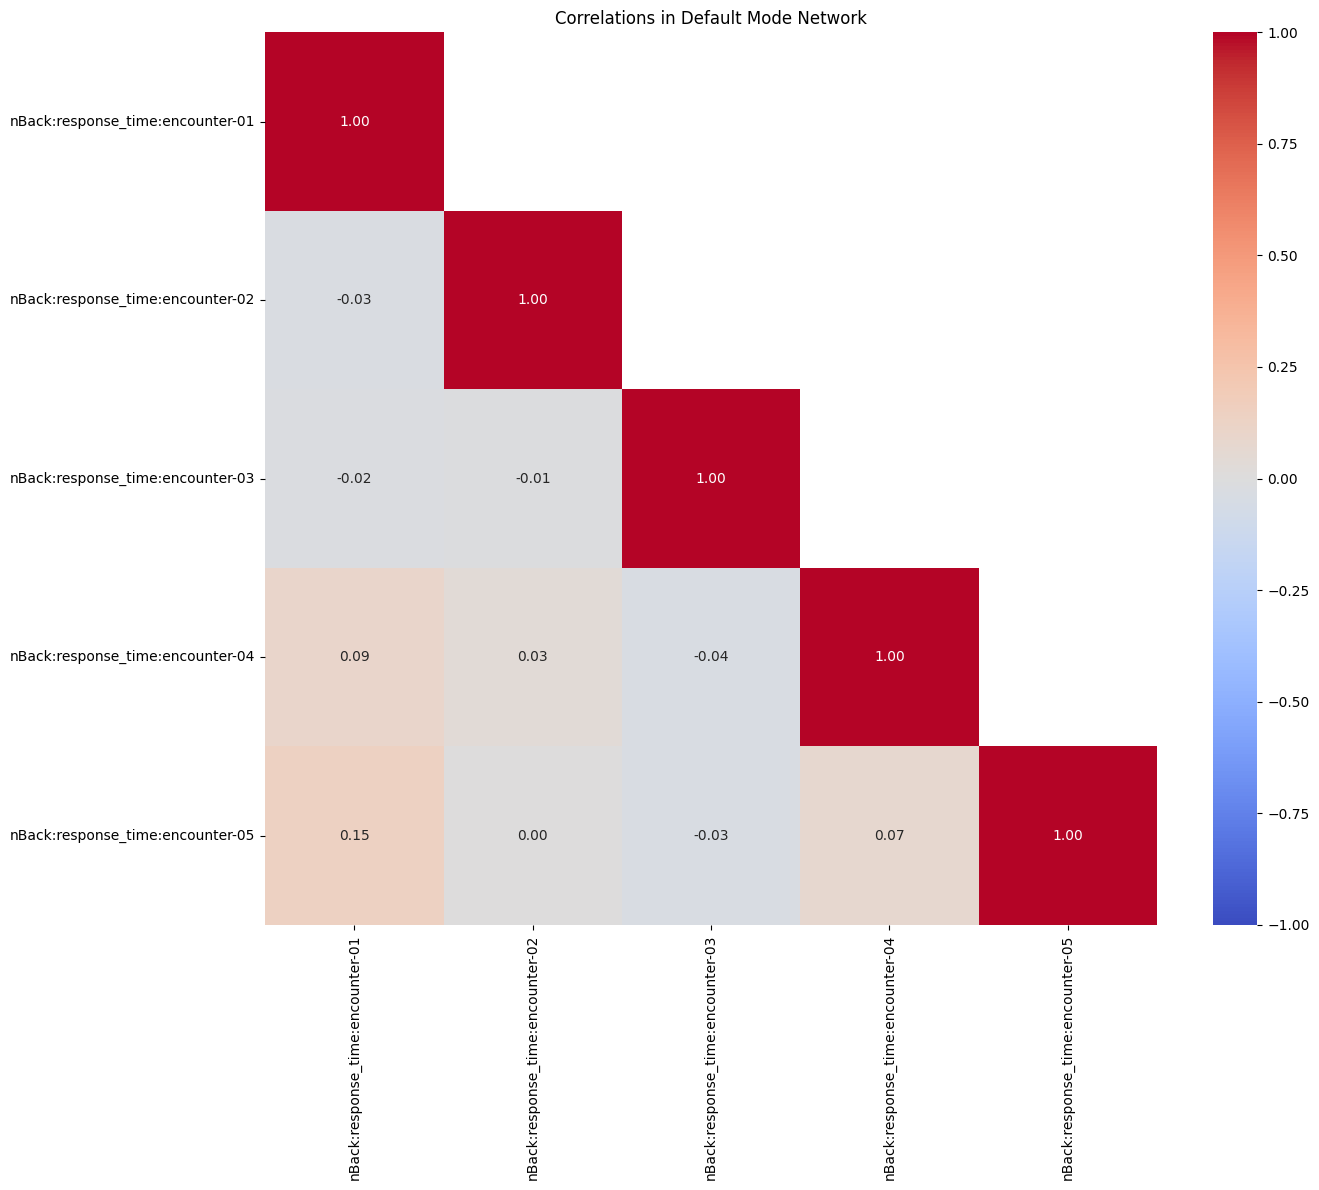

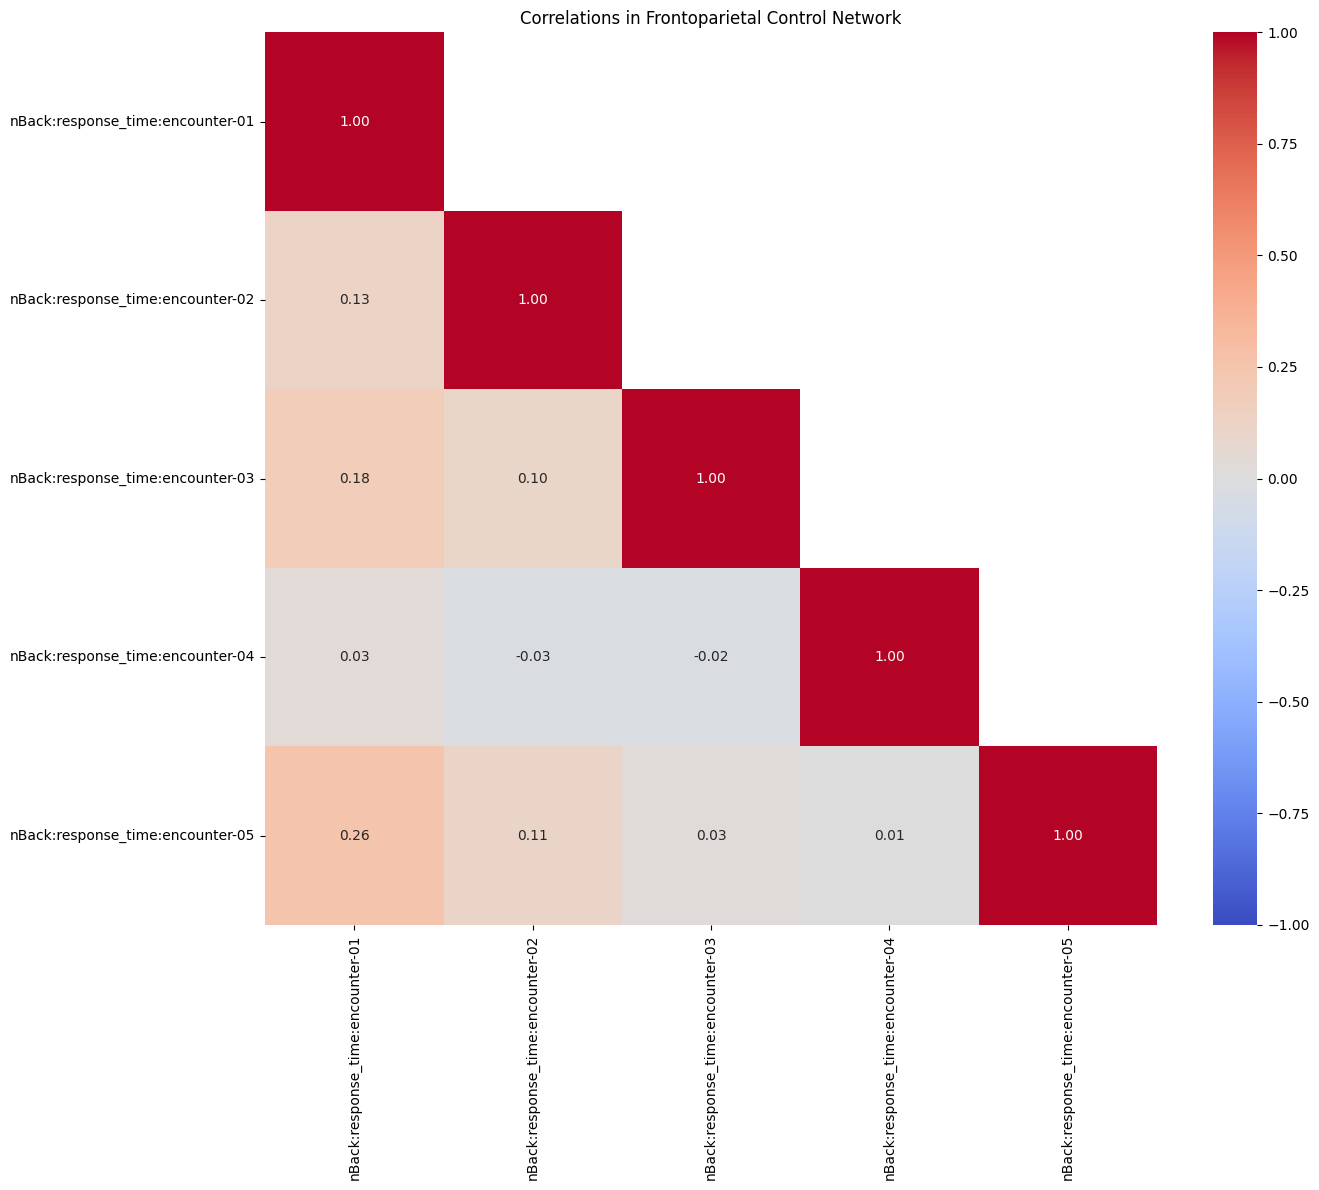

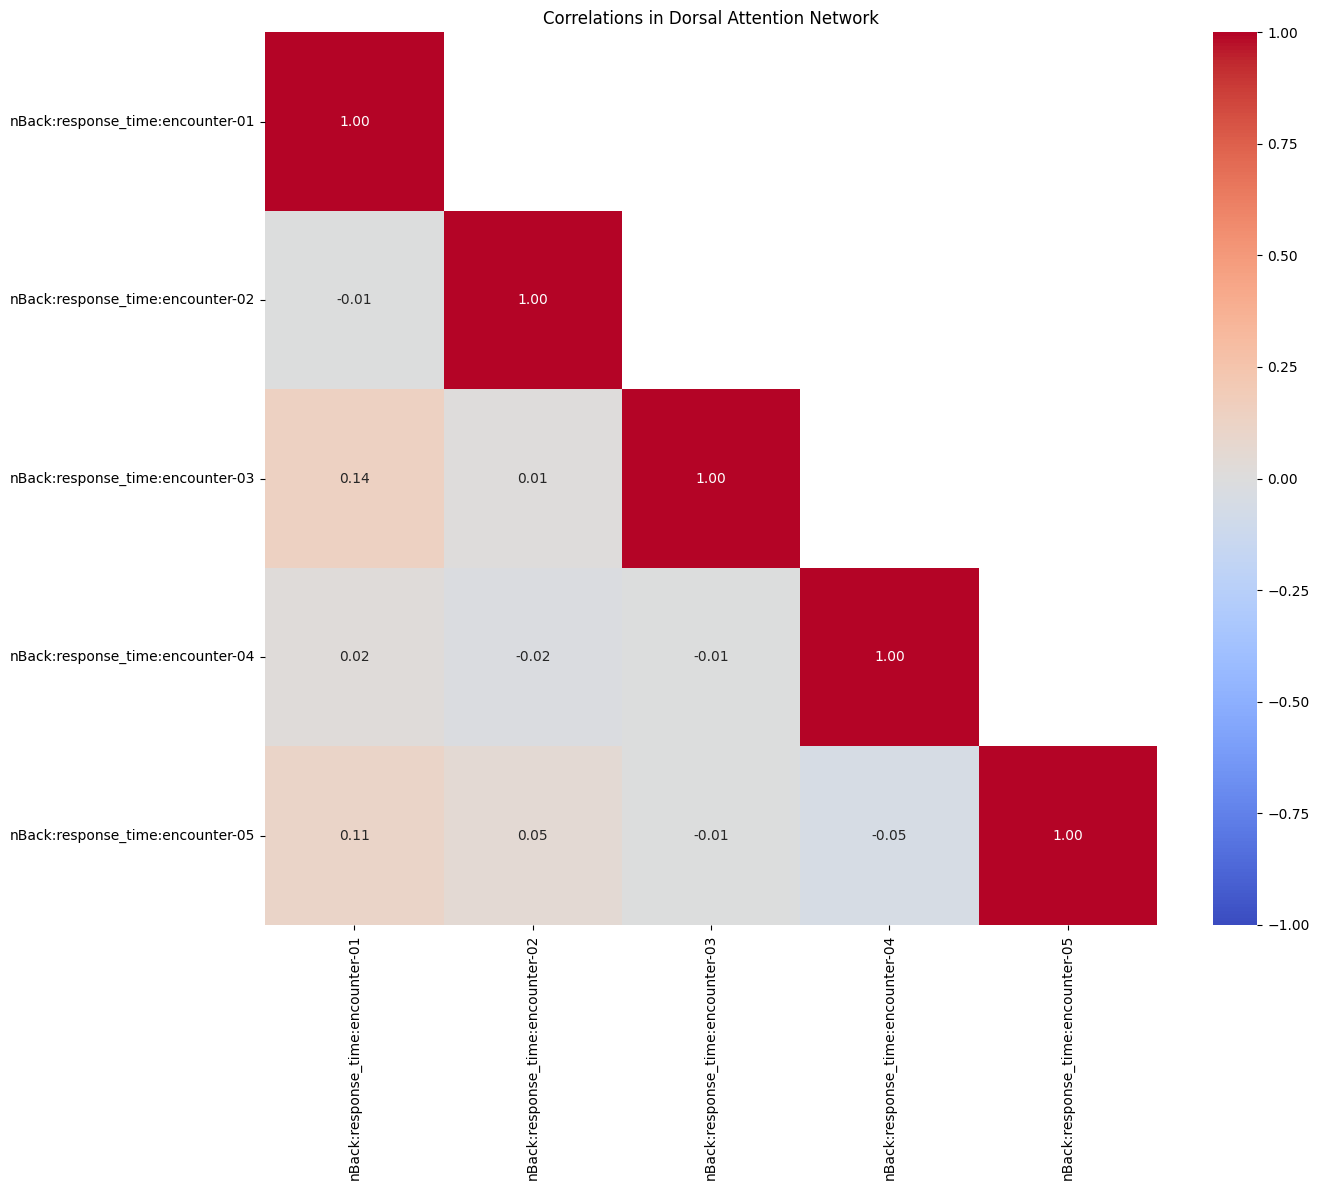

In [17]:
# TEST: run this with nBack one contrast at a time
requested_tasks = ["nBack"]
requested_contrasts = {}
# requested_contrasts["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"]
requested_contrasts["nBack"] = ["response_time"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[7])
plot_network_correlations(net_results, network_names[6])
plot_network_correlations(net_results, network_names[3])

In [ ]:
# check rest of individual contrasts for the tasks

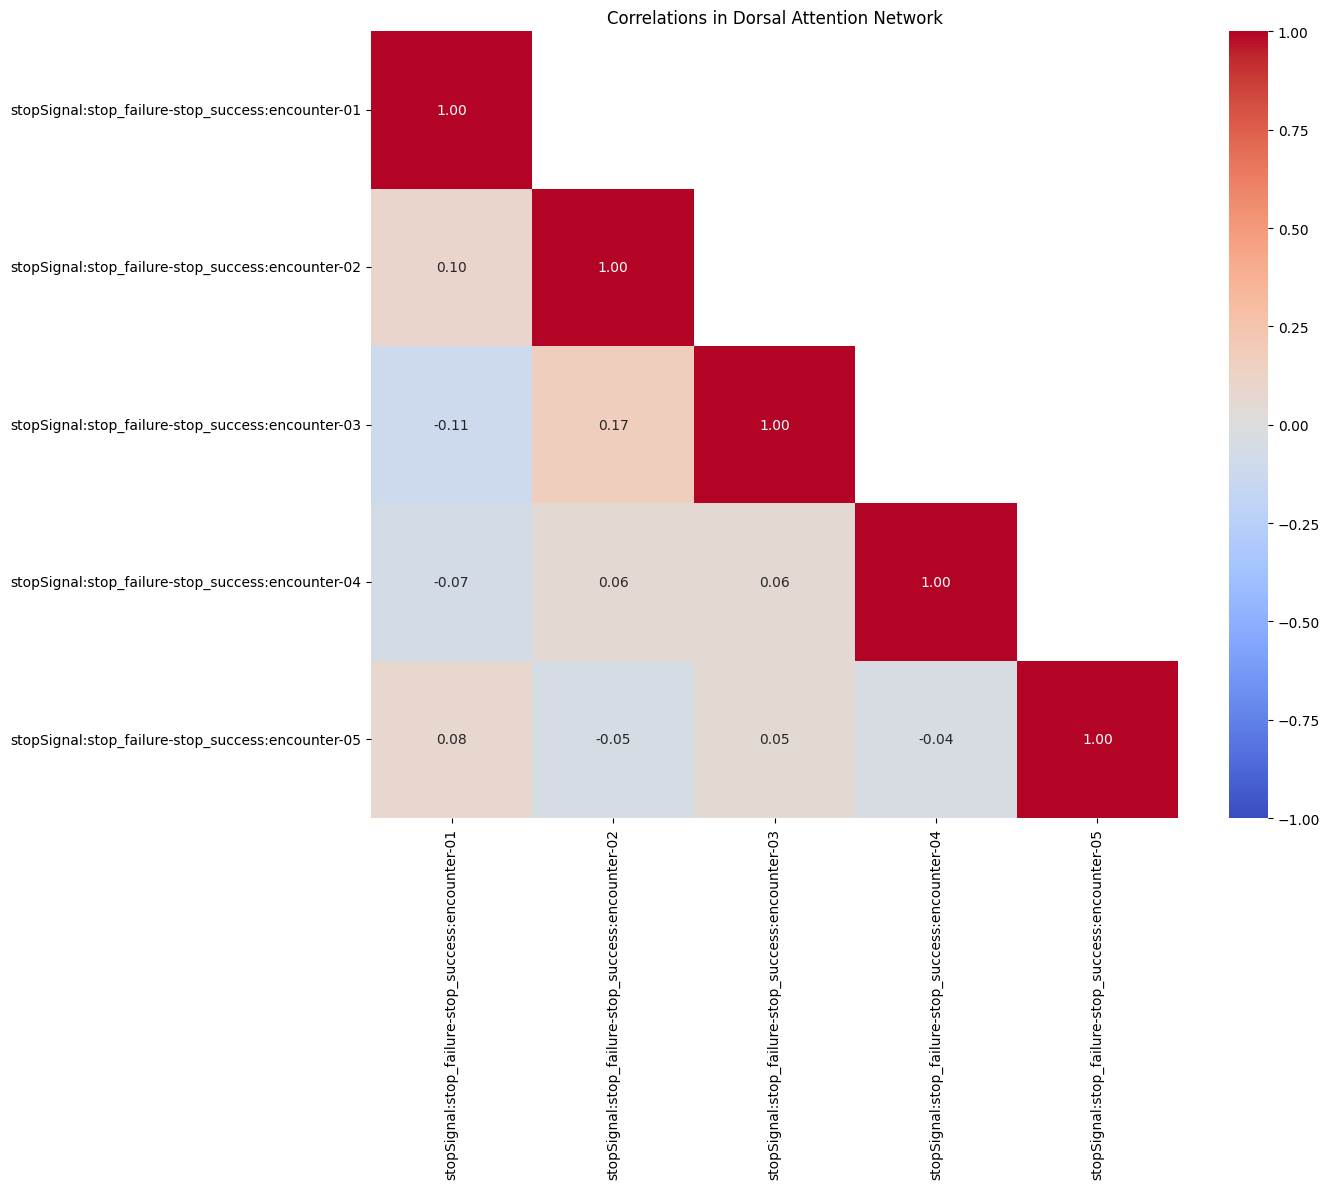

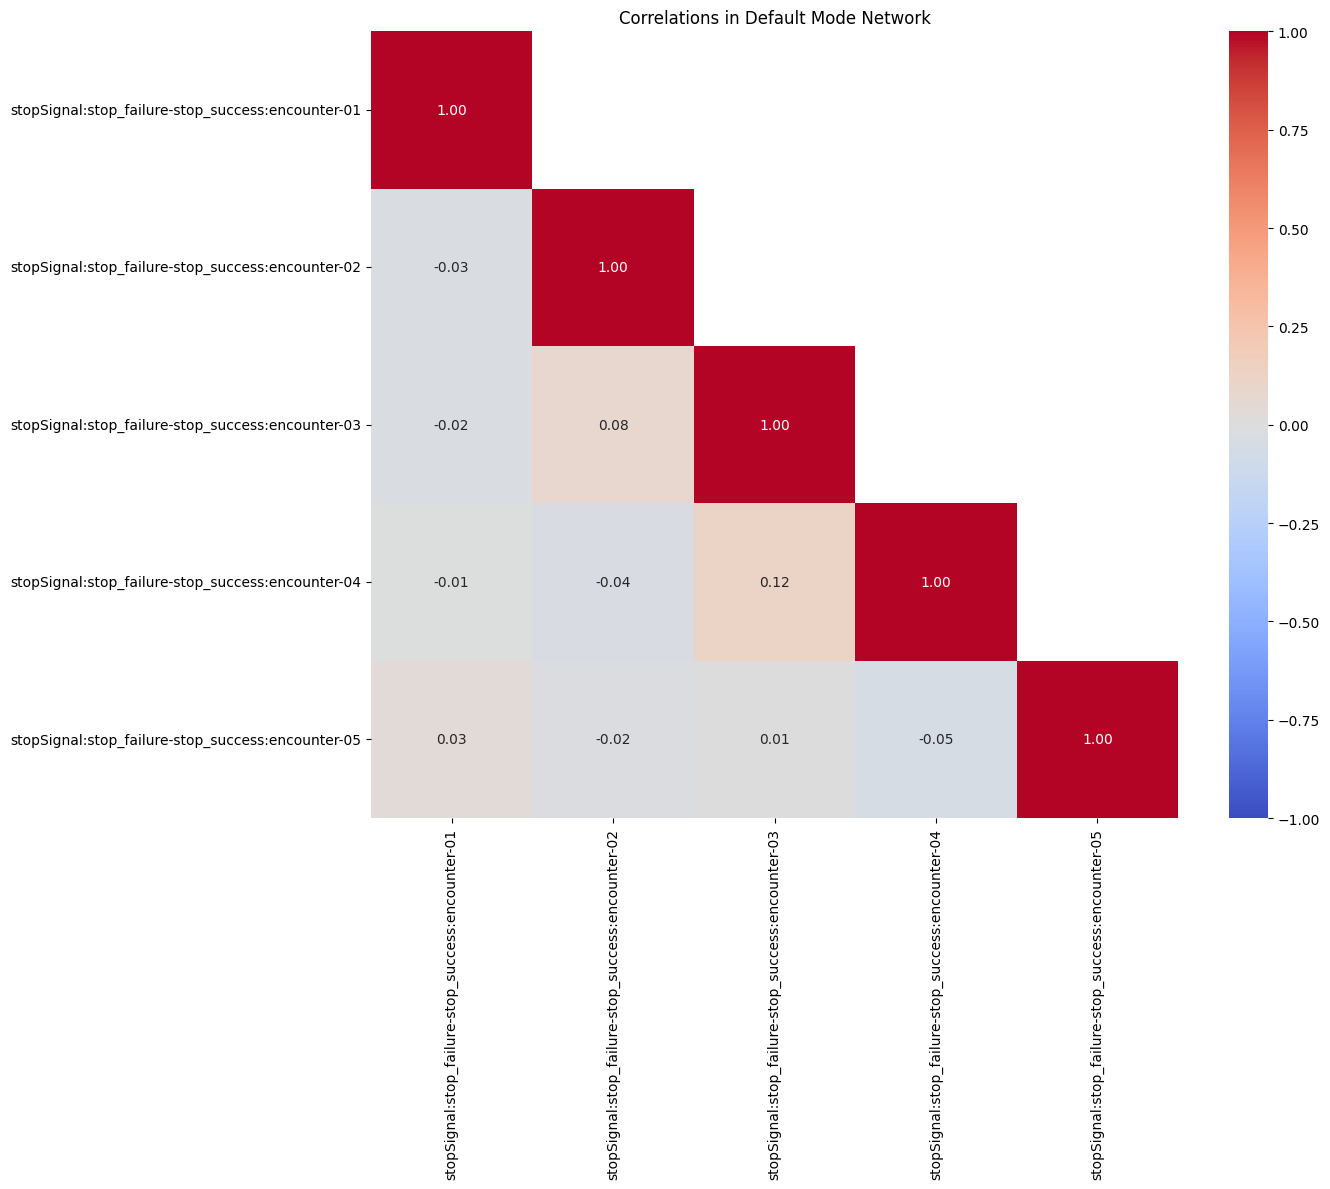

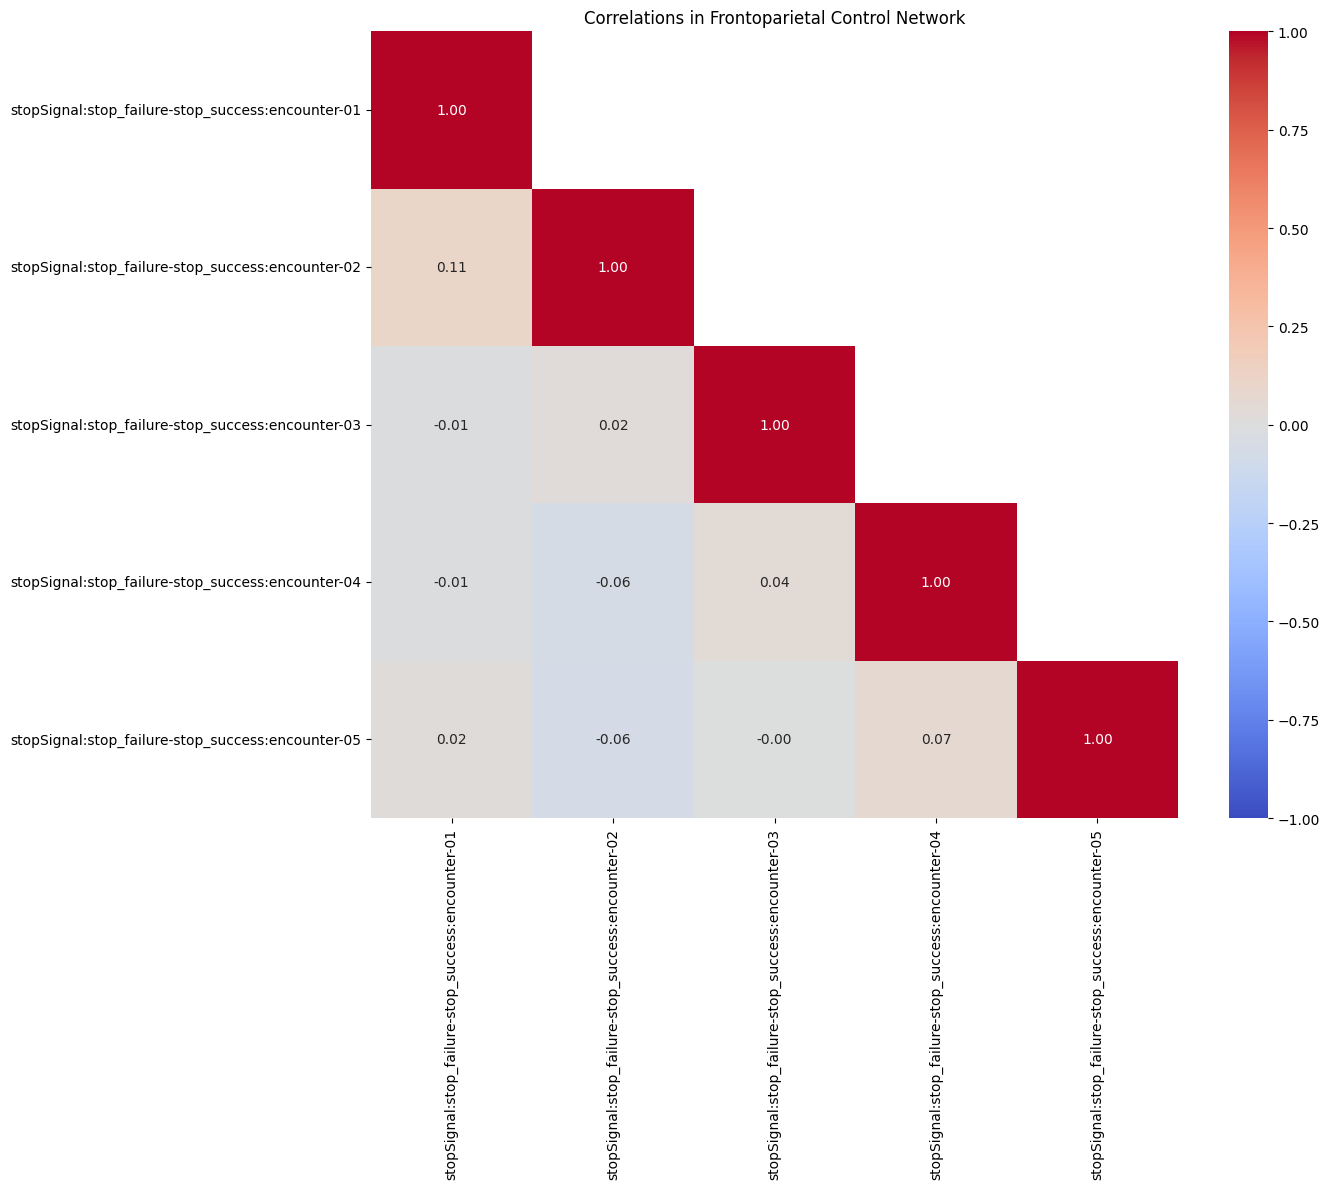

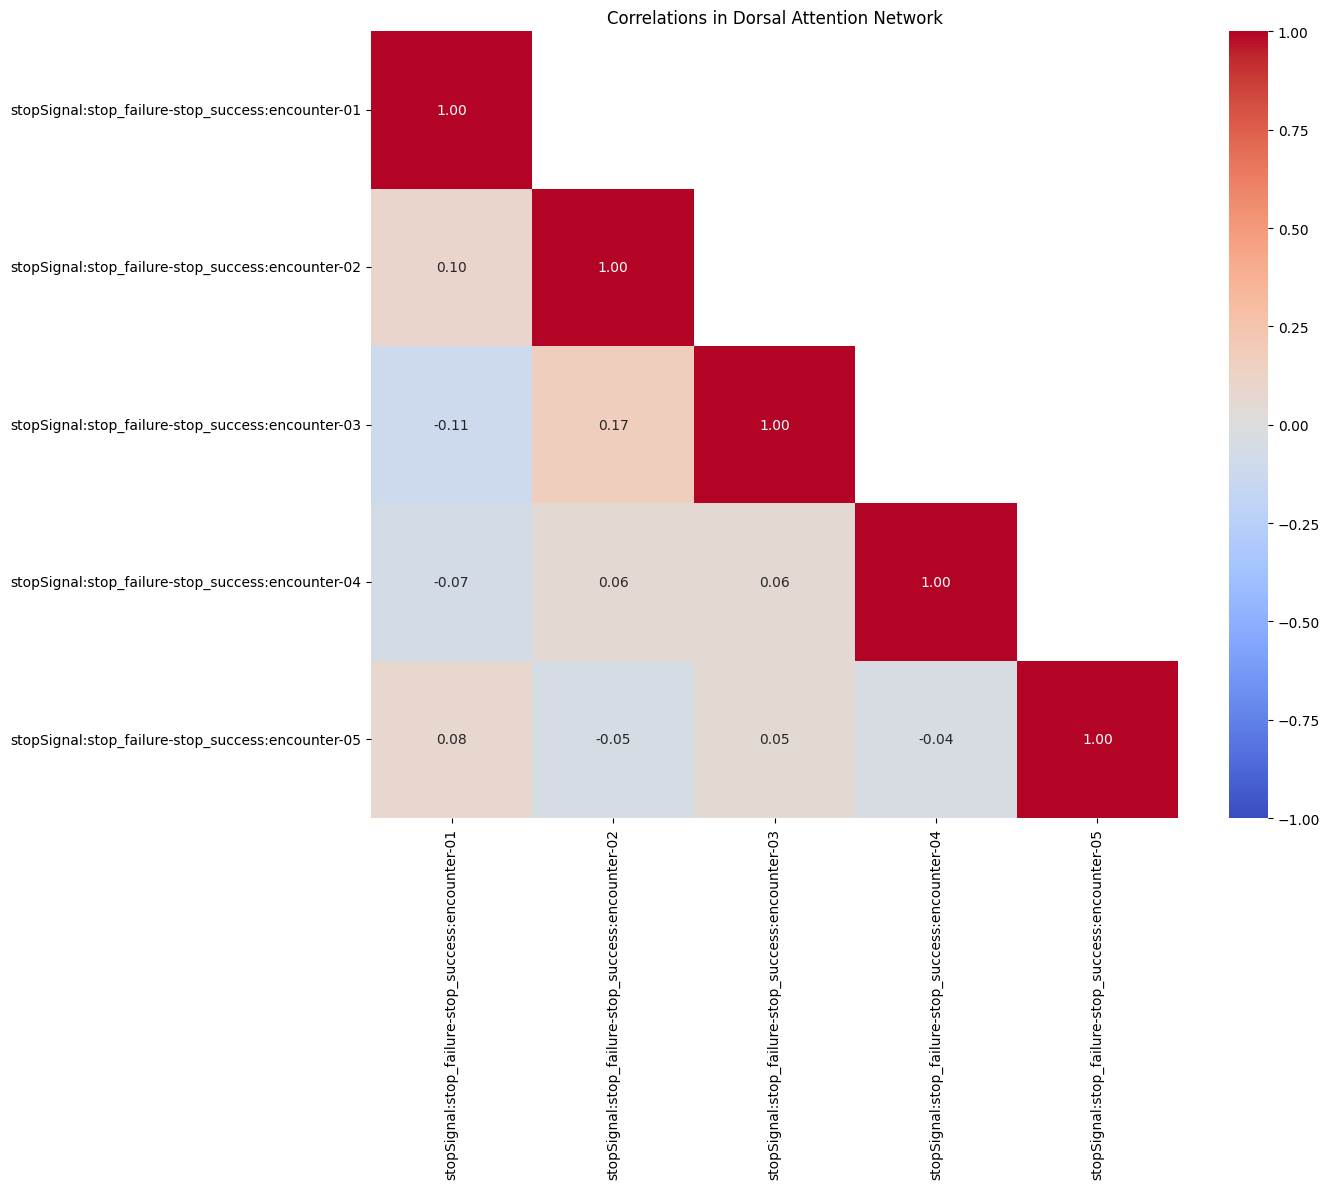

In [22]:
# TEST: run this with stop signal one contrast at a time
requested_tasks = ["stopSignal"]
requested_contrasts = {}
# ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
requested_contrasts["stopSignal"] = ["stop_failure-stop_success"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[7])
plot_network_correlations(net_results, network_names[6])
plot_network_correlations(net_results, network_names[3])

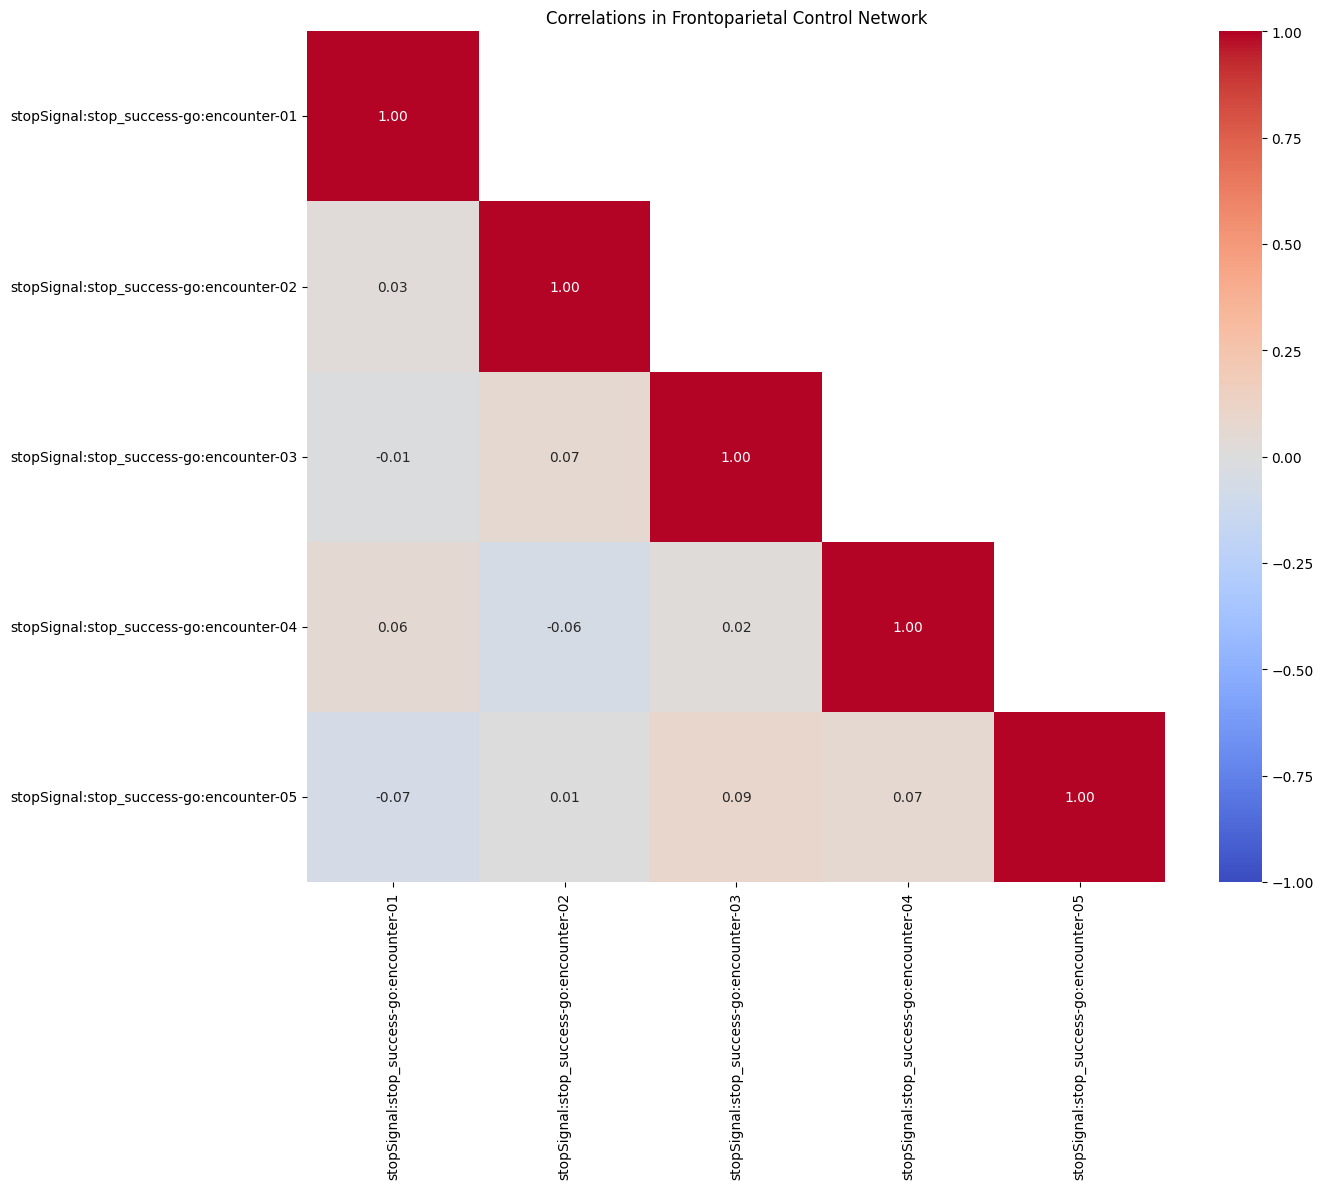

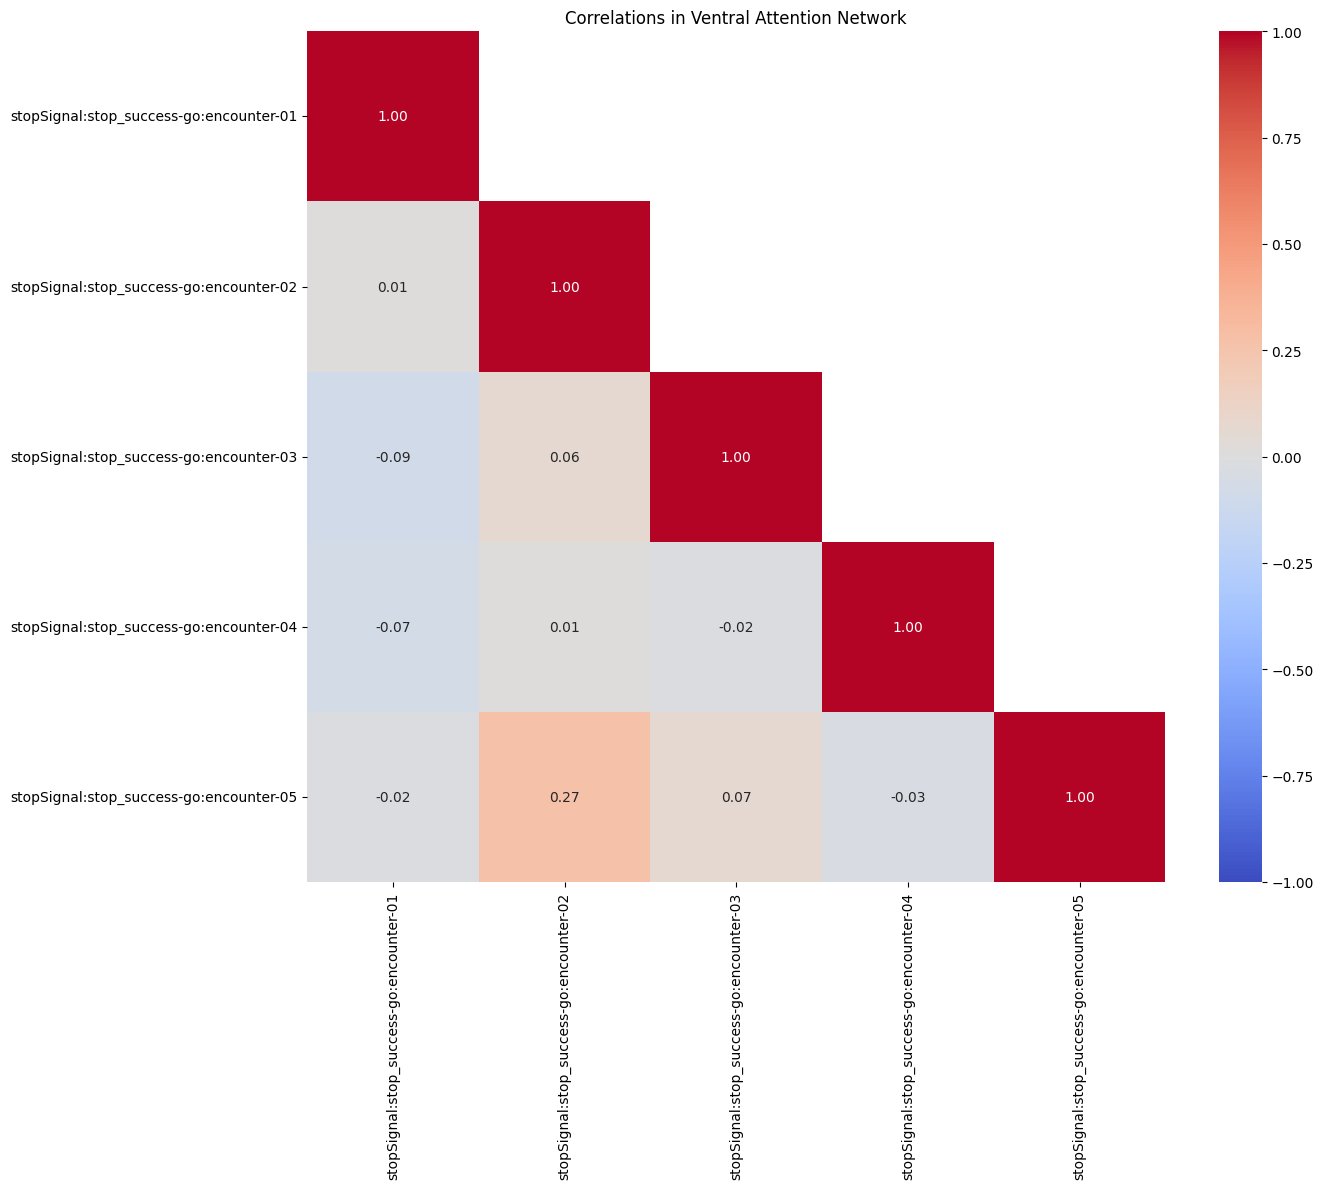

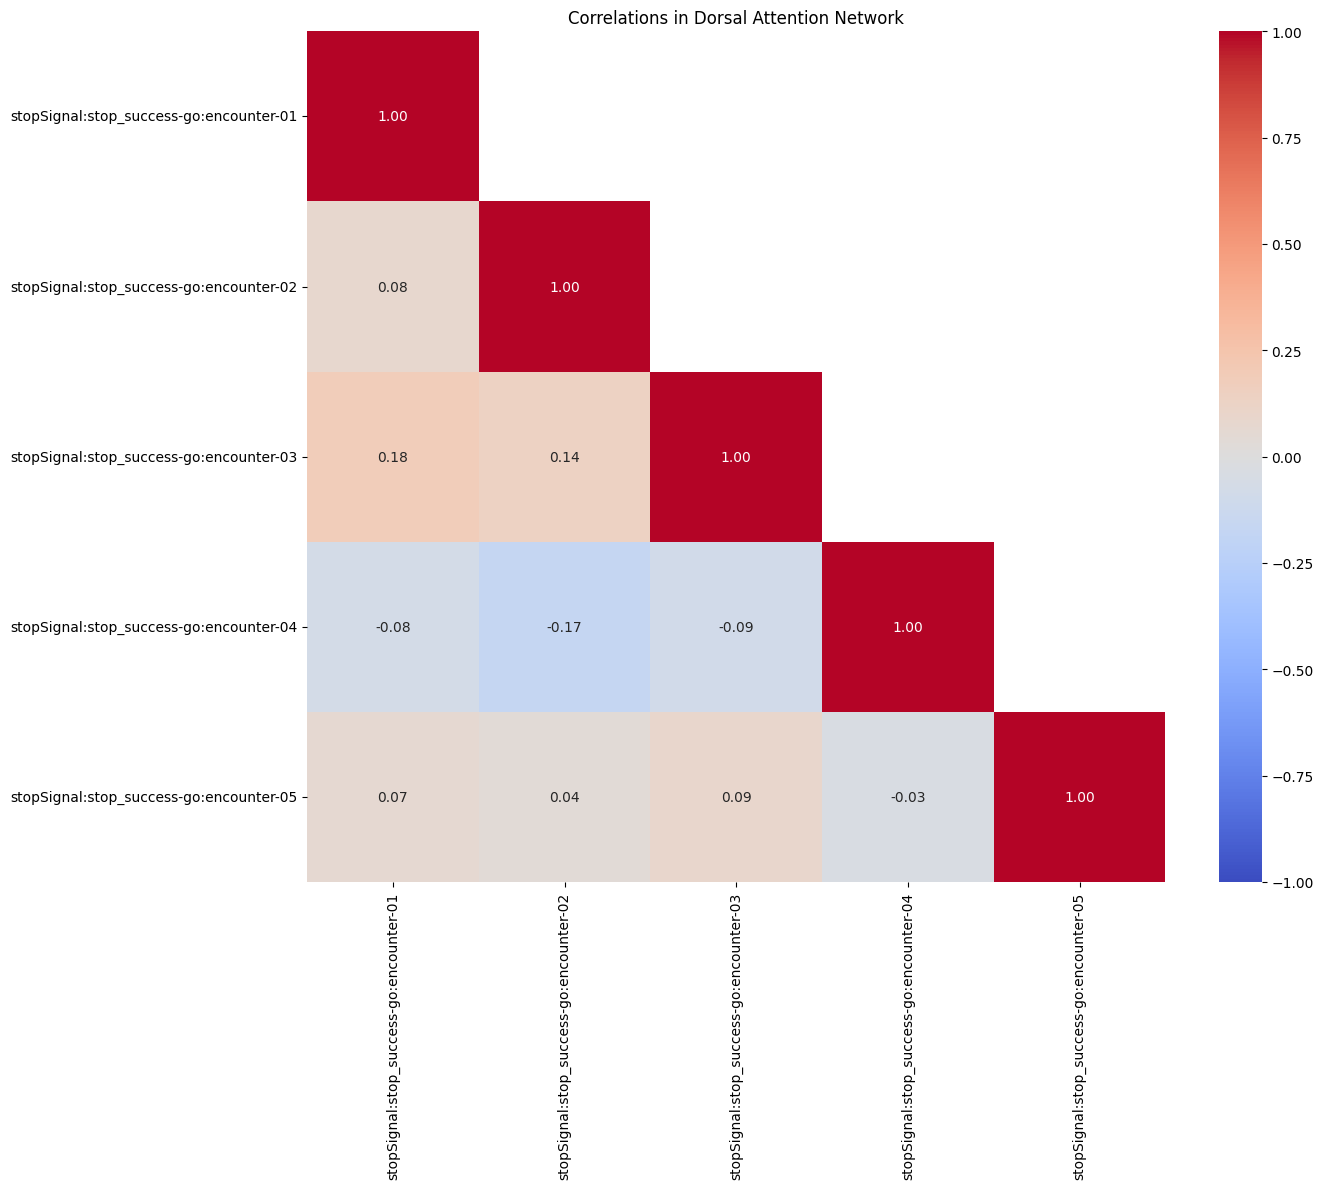

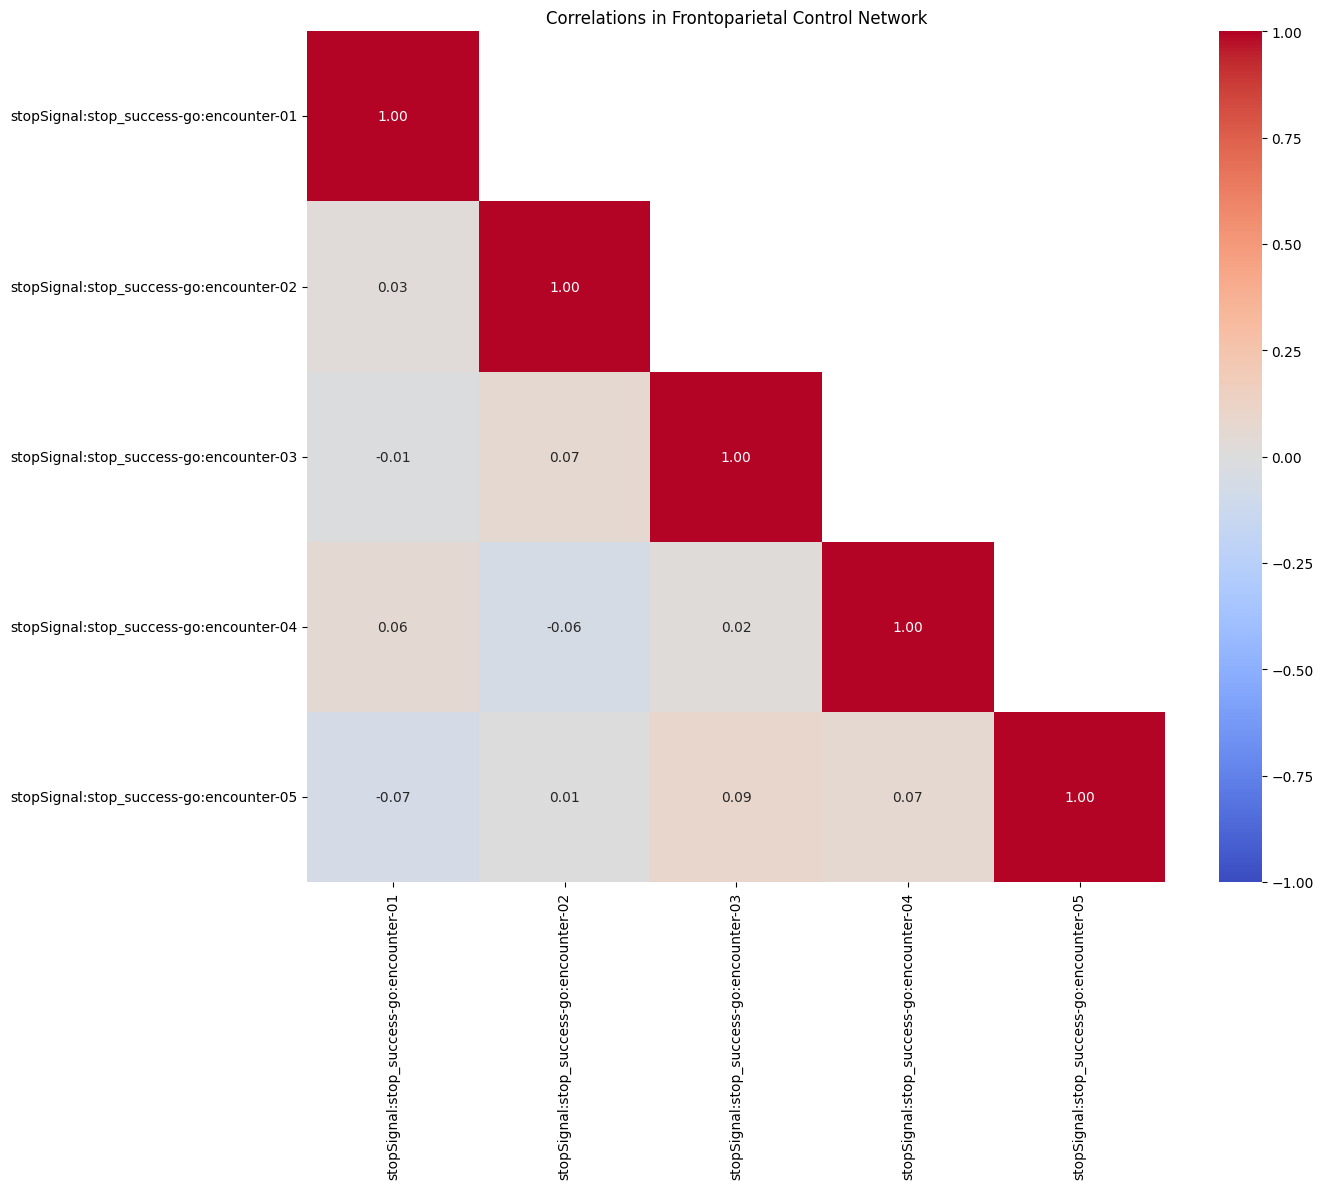

In [23]:
# network_names = {
#     1: "Visual",
#     2: "Somatomotor",
#     3: "Dorsal Attention",
#     4: "Ventral Attention",
#     5: "Limbic",
#     6: "Frontoparietal Control",
#     7: "Default Mode"
# }

# TEST: run this with stopsignal one contrast at a time
requested_tasks = ["stopSignal"]
requested_contrasts = {}
# ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
requested_contrasts["stopSignal"] = ["stop_success-go"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[4])
plot_network_correlations(net_results, network_names[3])
plot_network_correlations(net_results, network_names[6])

# check how inter-correlated the networks are across sessions (in progress; code not working for now)

In [18]:
def analyze_network_interactions(zmaps, desc_list, session_ids, yeo_img, network_names):
    """
    Analyze interactions between different brain networks across sessions.
    
    Parameters:
    -----------
    zmaps : list
        List of z-maps (3D activation maps)
    desc_list : list
        List of descriptive strings for each z-map
    session_ids : list
        List of session IDs to analyze
    yeo_img : nibabel.Nifti1Image
        Yeo atlas image resampled to match the z-maps
    network_names : list
        List of network names
        
    Returns:
    --------
    dict
        Dictionary with session IDs as keys, each containing a correlation matrix and network names
    """
    network_interaction_results = {}
    
    for session in session_ids:
        # Get indices for this session
        session_str = f"encounter_{session}"
        indices = [i for i, desc in enumerate(desc_list) if session_str in desc]
        
        if not indices:
            print(f"No data found for session {session} lol")
            continue
            
        # Get maps for this session
        session_maps = [zmaps[i] for i in indices]
        
        # Skip background/non-network regions (usually index 0)
        network_indices = list(network_names.keys())  # Get all keys from the dictionary
        networks_to_analyze = [network_names[i] for i in network_indices]  # Get network names by key

        # Create a correlation matrix for network interactions
        n_networks = len(networks_to_analyze)
        network_corr_matrix = np.zeros((n_networks, n_networks))
        
        # For each network pair, calculate mean correlation
        for i, net1_idx in enumerate(network_indices):
            net1_mask = (yeo_img.get_fdata() == net1_idx)
            
            for j, net2_idx in enumerate(network_indices):
                if i == j:  # Self-correlation is always 1
                    network_corr_matrix[i, j] = 1.0
                    continue
                
                net2_mask = (yeo_img.get_fdata() == net2_idx)
                
                # Calculate spatial correlation between networks across all maps
                correlations = []
                for map_data in session_maps:
                    # Extract values for each network
                    net1_values = map_data[net1_mask].flatten()
                    net2_values = map_data[net2_mask].flatten()
                    
                    # Only calculate if we have enough data points
                    if len(net1_values) > 10 and len(net2_values) > 10:
                        # Calculate correlation
                        corr = np.corrcoef(net1_values, net2_values)[0, 1]
                        if not np.isnan(corr):
                            correlations.append(corr)
                
                # Average correlations across all contrasts in this session
                if correlations:
                    network_corr_matrix[i, j] = np.mean(correlations)
        
        # Store results for this session
        network_interaction_results[f"Session_{session}"] = {
            'correlation_matrix': network_corr_matrix,
            'network_names': networks_to_analyze
        }
    
    return network_interaction_results

In [19]:
def plot_network_interactions(network_interactions, session_id, cmap='coolwarm', figsize=(12, 10)):
    """
    Plot network-to-network interaction matrix for a specific session with interpretation guide.
    """
    session_key = f"Session_{session_id}" if not str(session_id).startswith("Session_") else session_id
    
    if session_key not in network_interactions:
        print(f"Session {session_id} not found in results")
        return None
    
    result = network_interactions[session_key]
    corr_matrix = result['correlation_matrix']
    network_names = result['network_names']
    
    # Create a figure with two subplots - heatmap and interpretation guide
    fig = plt.figure(figsize=figsize)
    
    # Plot correlation matrix
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
    sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, 
                annot=True, fmt=".2f", 
                xticklabels=network_names, yticklabels=network_names,
                square=True, ax=ax1)
    ax1.set_title(f"Network Interactions in Session {session_id}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    
    # Add interpretation guide
    ax2 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)
    ax2.axis('off')
    
    interpretation_text = """
    Interpretation Guide:
    
    High positive correlation (red):
    • Networks are functionally integrated
    • Similar activation/deactivation patterns
    • Cooperating in cognitive processing
    
    No correlation (white):
    • Independent functioning
    • Different roles in task processing
    
    Negative correlation (blue):
    • Anti-correlated activity
    • One network activates while other deactivates
    • Possible competitive relationship
    
    Changes across sessions may indicate:
    • Learning effects
    • Strategy shifts
    • Neural efficiency changes
    • Cognitive resource reallocation
    """
    
    ax2.text(0, 0.5, interpretation_text, fontsize=10, verticalalignment='center')
    
    # Add a section to show changes across sessions if requested
    ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    ax3.axis('off')
    ax3.text(0.5, 0.5, 
             "Tip: Compare this matrix across sessions to identify changes in network coordination over time.",
             fontsize=10, ha='center', va='center', style='italic')
    
    plt.tight_layout()
    return fig

def plot_network_interaction_changes(network_interactions, network_pair=None):
    """
    Plot how a specific network pair's correlation changes across sessions.
    If network_pair is None, shows the average correlation across all network pairs.
    """
    sessions = sorted([int(key.split('_')[1]) for key in network_interactions.keys()])
    
    if network_pair is None:
        # Track average network correlation across all pairs
        correlations = []
        for session in sessions:
            result = network_interactions[f"Session_{session}"]
            matrix = result['correlation_matrix']
            # Get upper triangle without diagonal (exclude self-correlations)
            triu_indices = np.triu_indices_from(matrix, k=1)
            mean_corr = np.mean(matrix[triu_indices])
            correlations.append(mean_corr)
            
        plt.figure(figsize=(10, 6))
        plt.plot(sessions, correlations, 'o-', linewidth=2)
        plt.xlabel('Session', fontsize=12)
        plt.ylabel('Average Network Correlation', fontsize=12)
        plt.title('Change in Overall Network Integration Across Sessions', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(sessions)
        
    else:
        # Track specific network pair
        network1, network2 = network_pair
        correlations = []
        
        for session in sessions:
            result = network_interactions[f"Session_{session}"]
            matrix = result['correlation_matrix']
            network_names = result['network_names']
            
            try:
                idx1 = network_names.index(network1)
                idx2 = network_names.index(network2)
                corr = matrix[idx1, idx2]
                correlations.append(corr)
            except ValueError:
                print(f"Network pair not found in session {session}")
                return
                
        plt.figure(figsize=(10, 6))
        plt.plot(sessions, correlations, 'o-', linewidth=2)
        plt.xlabel('Session', fontsize=12)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.title(f'Correlation Between {network1} and {network2} Across Sessions', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(sessions)
        
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

['nBack:task-baseline:encounter-01', 'nBack:task-baseline:encounter-02', 'nBack:task-baseline:encounter-03', 'nBack:task-baseline:encounter-04', 'nBack:task-baseline:encounter-05']
No data found for session 0 lol
No data found for session 1 lol
No data found for session 2 lol
No data found for session 3 lol
No data found for session 4 lol
Session 0 not found in results


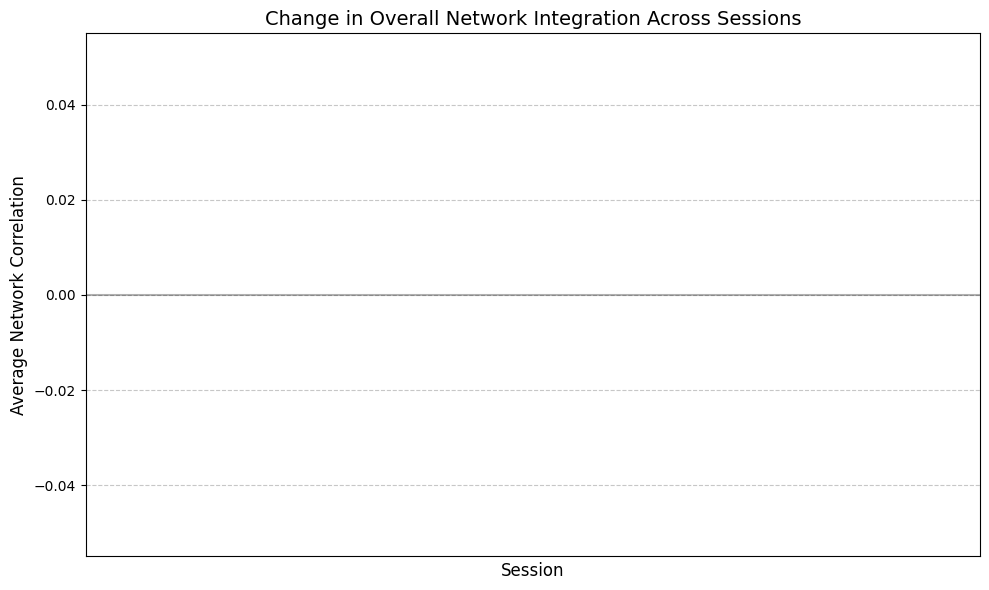

In [20]:
# doing this with task-baseline
requested_tasks = ["nBack"]
requested_contrasts = {}
requested_contrasts["nBack"] = ["task-baseline"]
requested_encounters = [0,1,2,3,4]
# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)


print(desc_list_nBack) 
network_interactions = analyze_network_interactions(
    zmaps_nBack, 
    desc_list_nBack, 
    requested_encounters, 
    yeo_resampled,
    network_names
)

# Plot the network interaction matrix for the first session (encounter 0)
fig_session0 = plot_network_interactions(network_interactions, 0)
plt.show()

# Plot how all network interactions change across sessions
fig_all_changes = plot_network_interaction_changes(network_interactions)
plt.show()

# # Identify important network pairs for n-Back task
# # These are examples - use your network_names actual values
# # For n-Back task, Frontoparietal and Default Mode are particularly interesting
# frontoparietal_index = -1
# default_mode_index = -1
# for i, name in enumerate(network_names):
#     if "front" in name.lower() or "control" in name.lower():
#         frontoparietal_index = i
#     if "default" in name.lower() or "dmn" in name.lower():
#         default_mode_index = i

# if frontoparietal_index >= 0 and default_mode_index >= 0:
#     # Plot how the correlation between these two networks changes
#     fig_fp_dm = plot_network_interaction_changes(
#         network_interactions, 
#         network_pair=(network_names[frontoparietal_index], network_names[default_mode_index])
#     )
#     plt.show()